<a id=contents></a>

# Exploratory Data Analysis
## Our clean data at a glance


[1. Visualizing and exploring the Job Title field](#insp)

[2. Text EDA of both categories](#one)

[3. Salary EDA](#two)

[4. EDA 3](#three)

[5. Conclusions and ideas going forward](#conc)

In [58]:

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
import string
# !pip install wordcloud
import wordcloud
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)

import warnings
warnings.filterwarnings('ignore')


import functions as fn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
stop_word_lst = fn.gen_stopwords(['learning','engineer', 'scientist', 'software', 'science', 'machine', 'data', 'analyst', 'experience', 'work', 'working'])

<a id=insp ><a/> 

## 1. Visualizing and exploring the Job Title field
    
[LINK to table of contents](#contents)

The job title field is a good starting point for our exploration because it's normally the first thing that someone exploring jobs will see (right before the salary) and tends to be a synthesis of the role in a few words. We'll be doing the EDA for this separately because we don't always wish to remove any stop words. The reason behind that is that job titles are limited in length and are less likely to contain uninformative words - each word that was purposefully put in there is significant, so we'll be passing an empty list to our stopword filtering parameter. Having said all that, analysing the titles will have great limitations because there's likely to be huge overlap (how many job posts will just have 'Data Scientist' in the title mixed in with some other words?). It'll be more difficult to pick out nuances from the title, and the description field will tell us more about what people can expect to be doing in their day-to-day role and what experience they might need.  

In [60]:
df = pd.read_csv('clean_data/jobs.csv', )
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

company  \
0  Medicines and Healthcare products Regulatory A...   
1                                                PwC   
2                                   Capital One - UK   
3                                            Globant   
4              UK Government - National Crime Agency   

                                           job_title  \
0                                CPRD Data Scientist   
1  Deals - Investigative Analytics - Data Scienti...   
2                             Data Scientist - Cyber   
3                                Lead Data Scientist   
4                     G4 Lead Data Scientist - Cyber   

                                           job_descr  \
0  would like reassure all applicant that recruit...   
1  career within Forensics Technology service wil...   
2  White Collar Factory 95009 United Kingdom Lond...   
3  are digitally native technology where innovati...   
4  Deploy analytical capability support operation...   

                                             job_url job_location  \
0  https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...          NaN   
1  https://www.indeed.co.uk/rc/clk?jk=7548e60a487...          NaN   
2  https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...          NaN   
3  https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...          NaN   
4  https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...          NaN   

   searched_data_analyst  searched__data_scientist  \
0                      0                         1   
1                      0                         1   
2                      0                         1   
3                      0                         1   
4                      0                         1   

   searched__machine_learning_engineer  salary_from_page_source_as_stated  \
0                                    0                            39853.0   
1                                    0                                NaN   
2                                    0                                NaN   
3                                    0                                NaN   
4                                    0                            35846.0   

   salary_from_page_source_conv_hourly salary_from_page_source_time_period  \
0                                21.00                                   Y   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  NaN                                 NaN   
4                                18.89                                   Y   

   Num_reviews  id  
0         18.0   0  
1       7678.0   1  
2       8902.0   2  
3          NaN   3  
4         32.0   4

In [61]:
df.job_descr.duplicated().value_counts()

False    2016
True      195
Name: job_descr, dtype: int64

In [62]:
df.job_descr.drop_duplicates(inplace=True)

In [63]:
df.job_descr.nunique()

2016

We start of by plotting the unigram term frequecy across all DS and ML jobs. It's unsurprising that 'Data' and 'Engineer' come up at such high places with over 450 occurences. This grap isn't necessarily giving us that much information, because most of these are buzzwords on their own. We can start to make sense by looking at bigrams further below.

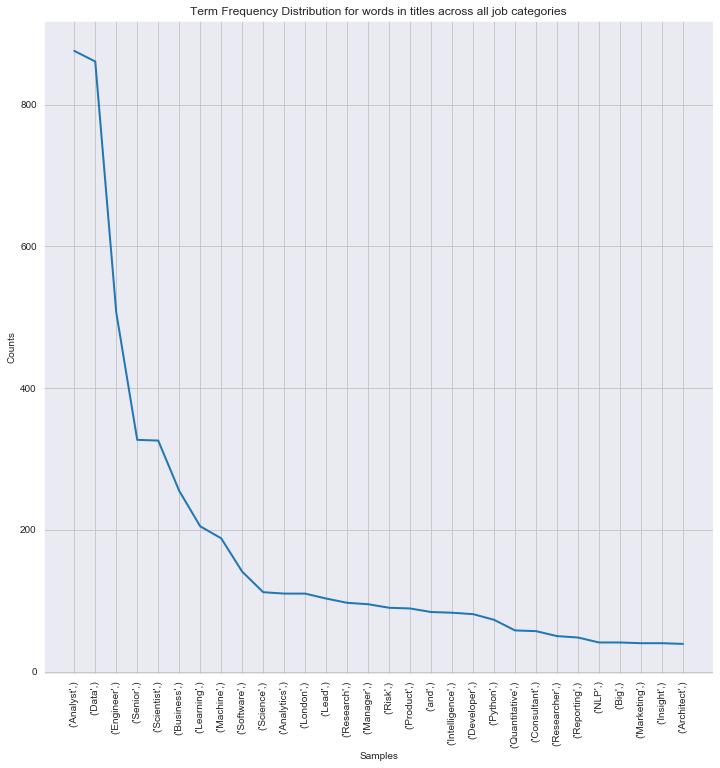

In [64]:
fn.plot_freqdist_from_series(df.job_title, tokenizer, [], 'Term Frequency Distribution for words in titles across all job categories', figsize=(12,12), num_terms=30, lower_case=False);

A few more unsurprising leads come up with 'Data Scientist' and 'Machine Learning' being at the very top. This is not as informative because these are explicitly the categories we were already looking at and scraping for. However, lower down the list we find other more useful info, e.g. 'Product Manager', 'Computer Vision'. Nevertheless, buzzword terms and titles are dominating the distribution. Let's try plotting bigrams again with stopword filtering. I modified the stopword list in the functions.py file to include punctuation as well as 'scientist', 'engineer' and other redundant terms.

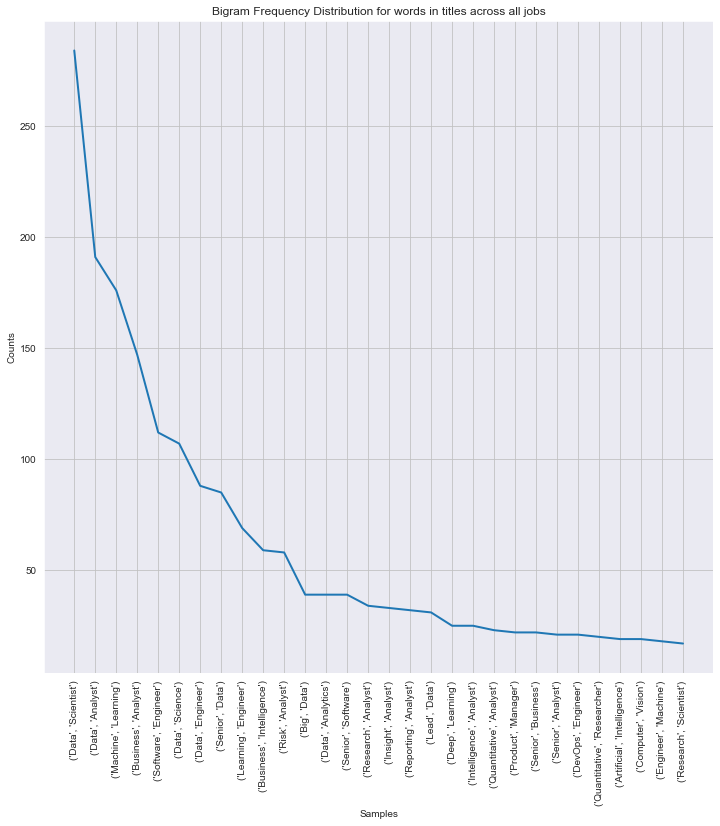

In [65]:
fn.plot_freqdist_from_series(df.job_title, tokenizer, [], 'Bigram Frequency Distribution for words in titles across all jobs', 
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);

Now we can identify the total number of bigrams for these more unique combinations. 'Product Manager' clocks in at 22, 'Computer Vision' at 19. This is nevertheless dwarfed by the previous bigrams we had, which were an order of magnitude higher in frequency. Given that we have just over 1000 unique job descriptions, 'Product Manager' appears in roughly 2% of job posts, hardly a significant trend. 'Computer Vision' appears in even less so **if** this sampling of job descriptions is representative of the job market trends (which is a big _if_) computer vision jobs are not in a lot of demand right now.

Some terms are not coming up as intended though ('natural language' and 'language processing') and seem to have been truncated - we'll plot trigrams next to try to determine these. 

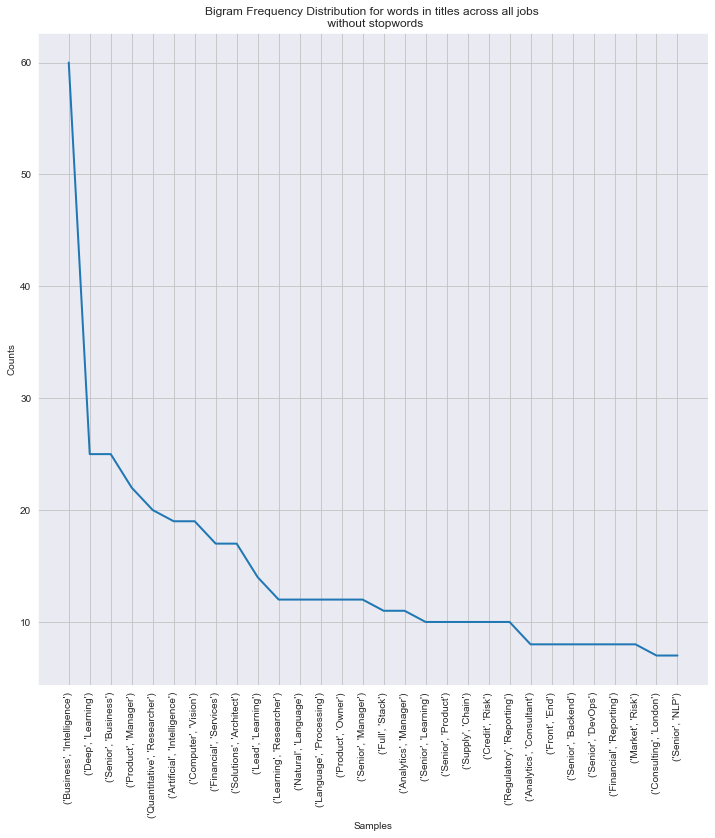

In [66]:
fn.plot_freqdist_from_series(df.job_title, tokenizer, stop_word_lst, 'Bigram Frequency Distribution for words in titles across all jobs \n without stopwords', 
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);

For trigrams without stopwords we see different contenders cropping up, but 'Natural language processing' only registers at around 12, so barely 1% of the job titles. It's worth noting that at this point we start to see outliers like 'Full Stack Developer' and 'Scientific Writing Advocacy'. Whilst they are neither Data Scientist nor ML Engineering jobs, I can see why they would come up for those search terms. The trigrams with stopwords included gave us more information at this point. 

For someone like me it's promising to see that 'Senior Data Scientist' only covers about 5% of the job posts - it's also a bit worrying that 'Junior Data Scientist' doesn't even appear in the top 30 trigrams.

Next we should look at how this changes when we plot the Frequency distributions separately for DS and for ML Engineer searches.

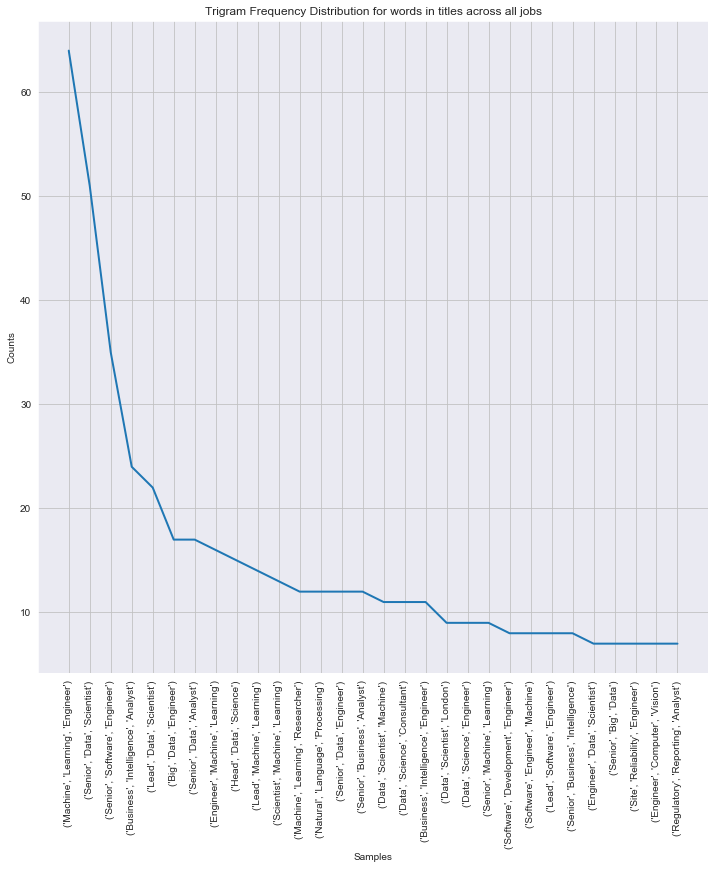

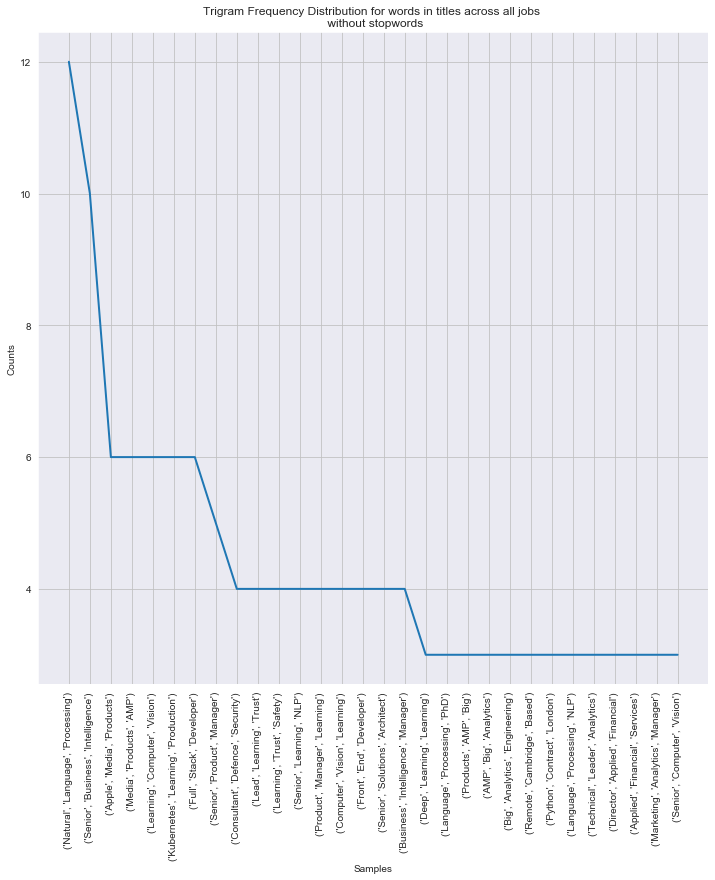

In [67]:
fn.plot_freqdist_from_series(df.job_title, tokenizer, [], 'Trigram Frequency Distribution for words in titles across all jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);
fn.plot_freqdist_from_series(df.job_title, tokenizer, stop_word_lst, 'Trigram Frequency Distribution for words in titles across all jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);

And now we begin to see that 'Senior' employees are in higher demand (15-20%) across both jobs, albeit more in Machine Learning Engineer jobs than DS. Again, single words don't give as much information, so we're better off looking at brigrams and trigrams.

In [68]:
df.rename(columns={'searched_data_analyst':'searched__data_analyst'}, inplace=True)

In [69]:
print('Total DS jobs     = ', len(df.loc[df.searched__data_scientist==1].job_title))
print('Total DA jobs     = ', len(df.loc[df.searched__data_analyst==1].job_title))
print('Total ML Eng jobs = ', len(df.loc[df.searched__machine_learning_engineer==1].job_title))

Total DS jobs     =  545
Total DA jobs     =  986
Total ML Eng jobs =  680


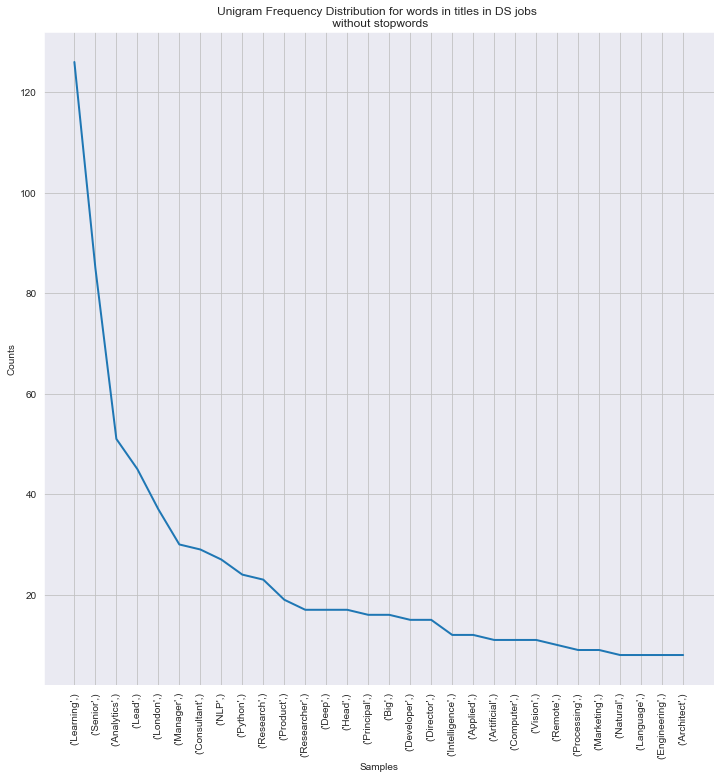

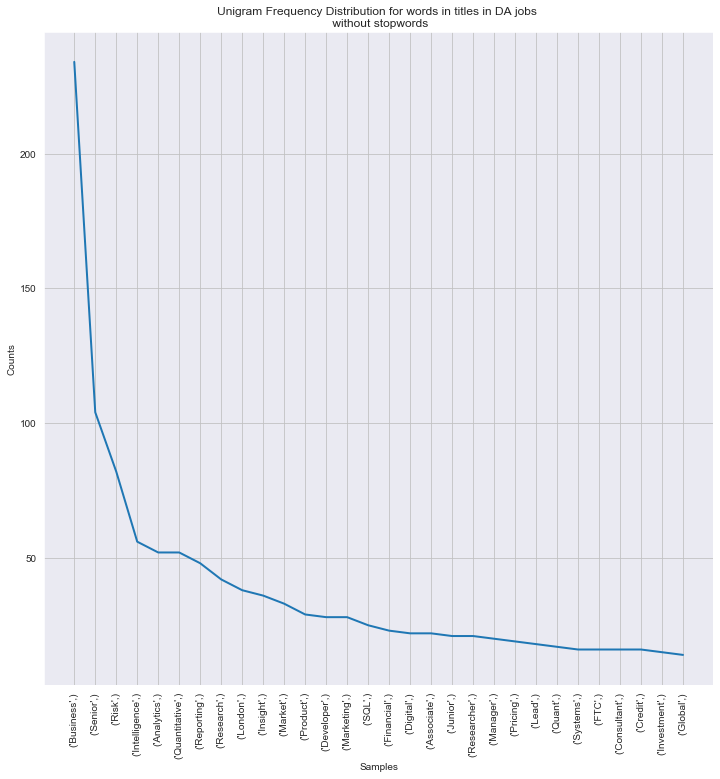

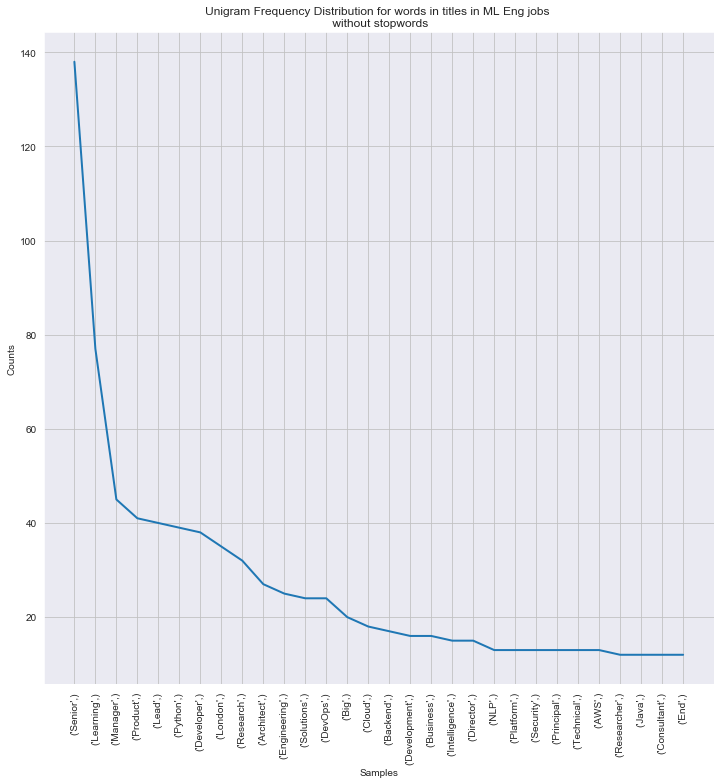

In [70]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, stop_word_lst, 'Unigram Frequency Distribution for words in titles in DS jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=1);
fn.plot_freqdist_from_series(df.loc[df.searched__data_analyst==1].job_title, tokenizer, stop_word_lst, 'Unigram Frequency Distribution for words in titles in DA jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=1);
fn.plot_freqdist_from_series(df.loc[df.searched__machine_learning_engineer==1].job_title, tokenizer, stop_word_lst, 'Unigram Frequency Distribution for words in titles in ML Eng jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=1);

The most surprising term is the 'Product Manager' at around 15% in ML Eng job posts - perhaps an indication that team leader and managerial roles are more in demand in this sample of ML jobs than they are in DS. 

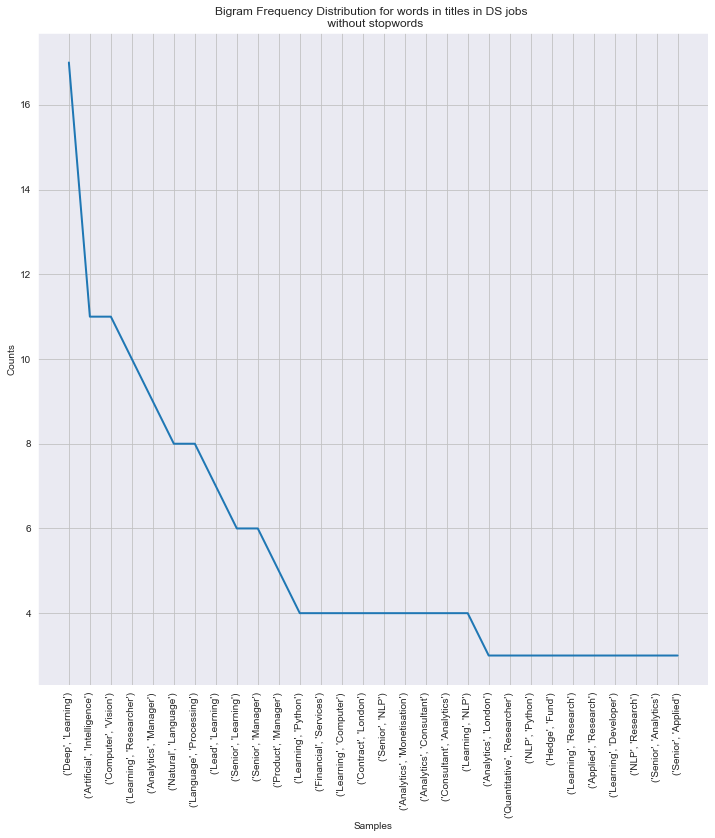

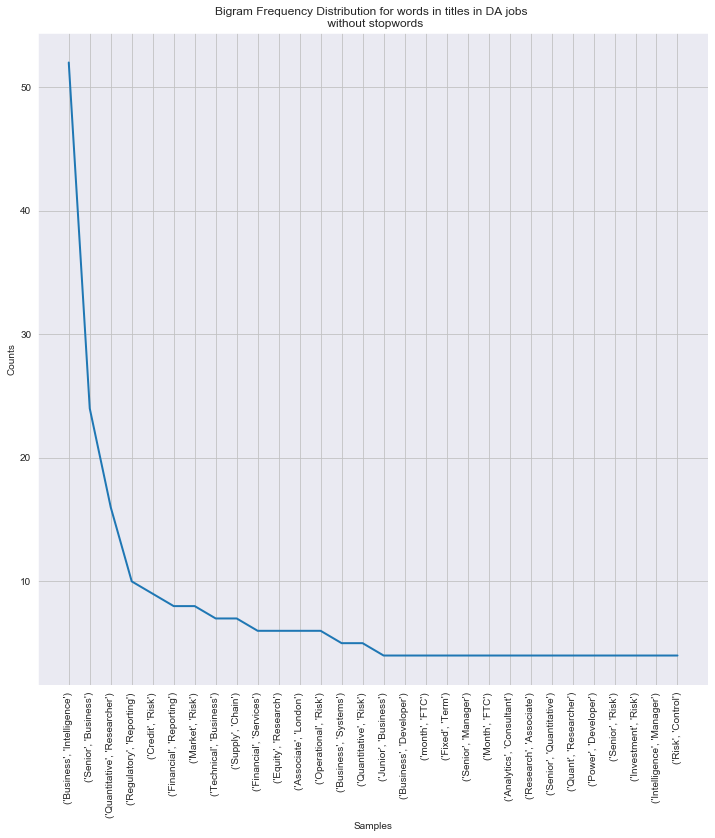

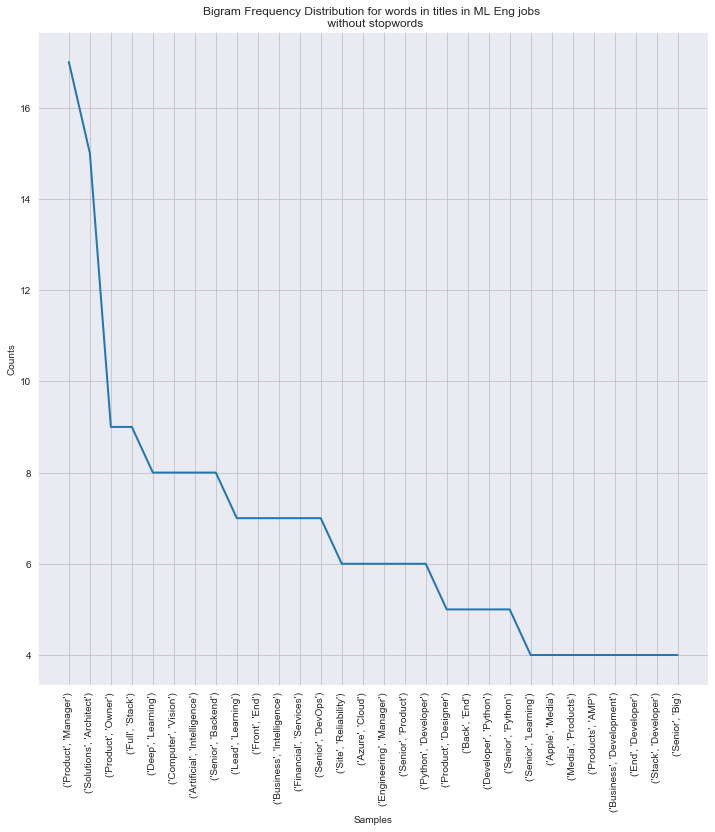

In [71]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, stop_word_lst, 'Bigram Frequency Distribution for words in titles in DS jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);
fn.plot_freqdist_from_series(df.loc[df.searched__data_analyst==1].job_title, tokenizer, stop_word_lst, 'Bigram Frequency Distribution for words in titles in DA jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);
fn.plot_freqdist_from_series(df.loc[df.searched__machine_learning_engineer==1].job_title, tokenizer, stop_word_lst, 'Bigram Frequency Distribution for words in titles in ML Eng jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);

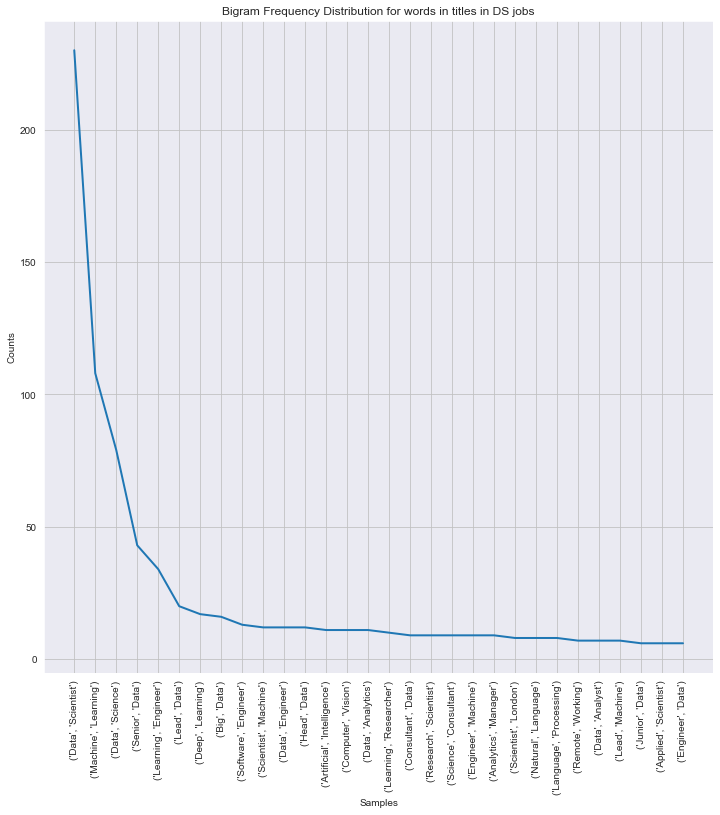

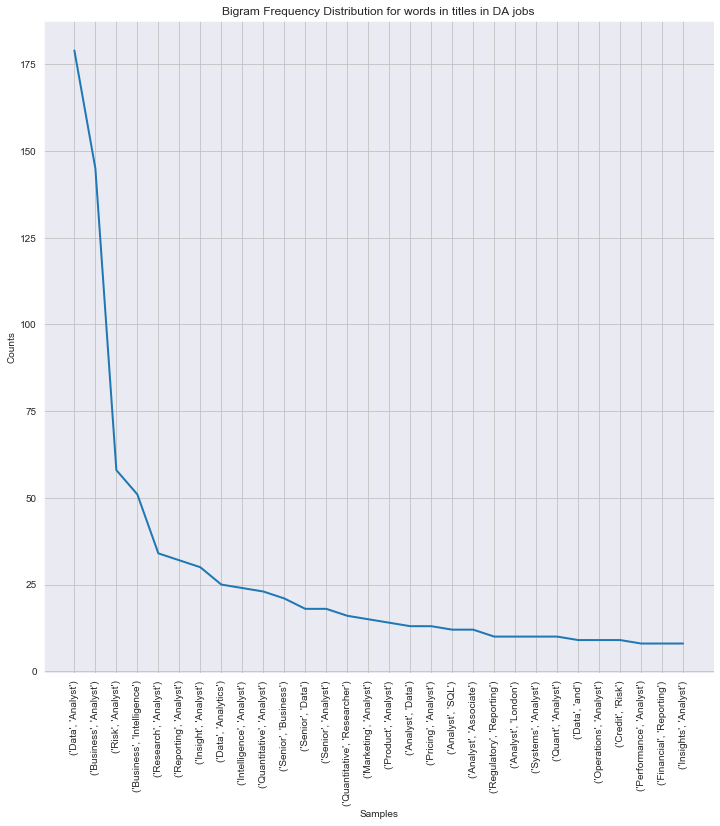

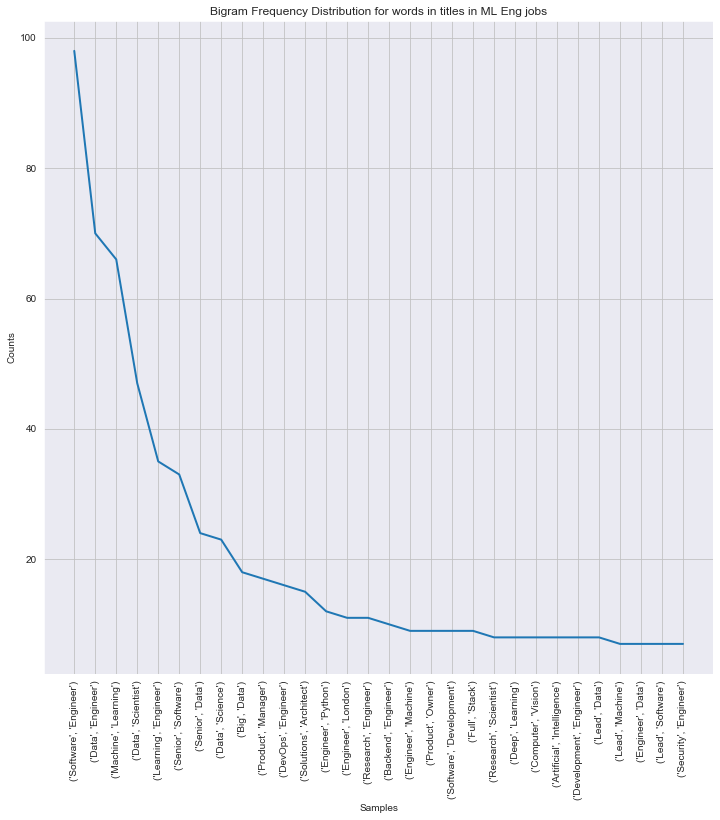

In [72]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, [], 'Bigram Frequency Distribution for words in titles in DS jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);
fn.plot_freqdist_from_series(df.loc[df.searched__data_analyst==1].job_title, tokenizer, [], 'Bigram Frequency Distribution for words in titles in DA jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);
fn.plot_freqdist_from_series(df.loc[df.searched__machine_learning_engineer==1].job_title, tokenizer, [], 'Bigram Frequency Distribution for words in titles in ML Eng jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);

The only terms of significance cropping up consistently are titles with 'Senior' in them - a worrying term if you're just starting out in your DS or MLeng career! However, this is still in less than 10% of jobs. It's also worth reminding ourselves that that doesn't mean the rest of the job pots *don't* require a lot of experience - plenty of jobs will mention some years of prior work (or mention needing a doctorate degree).

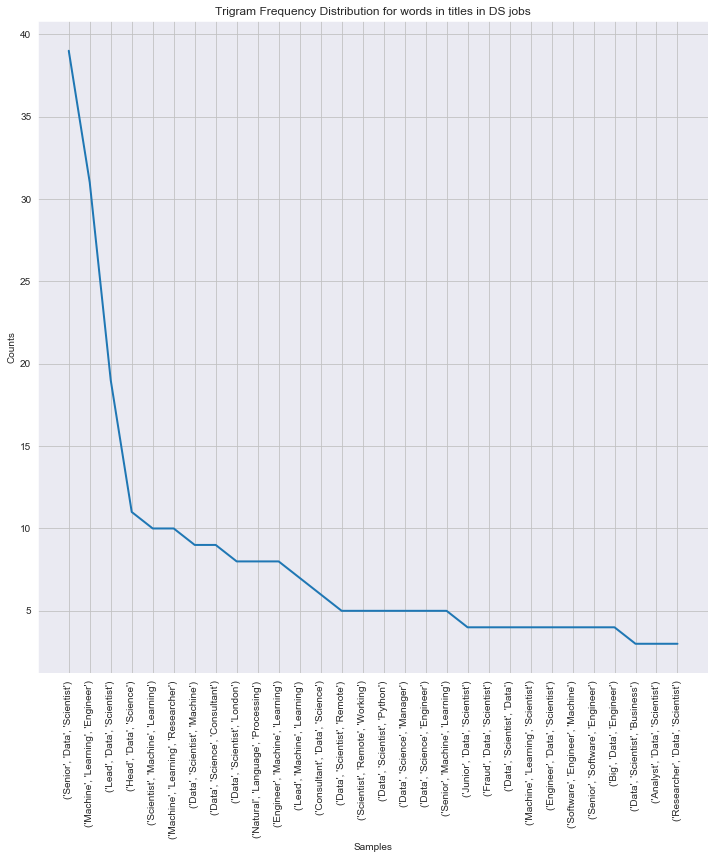

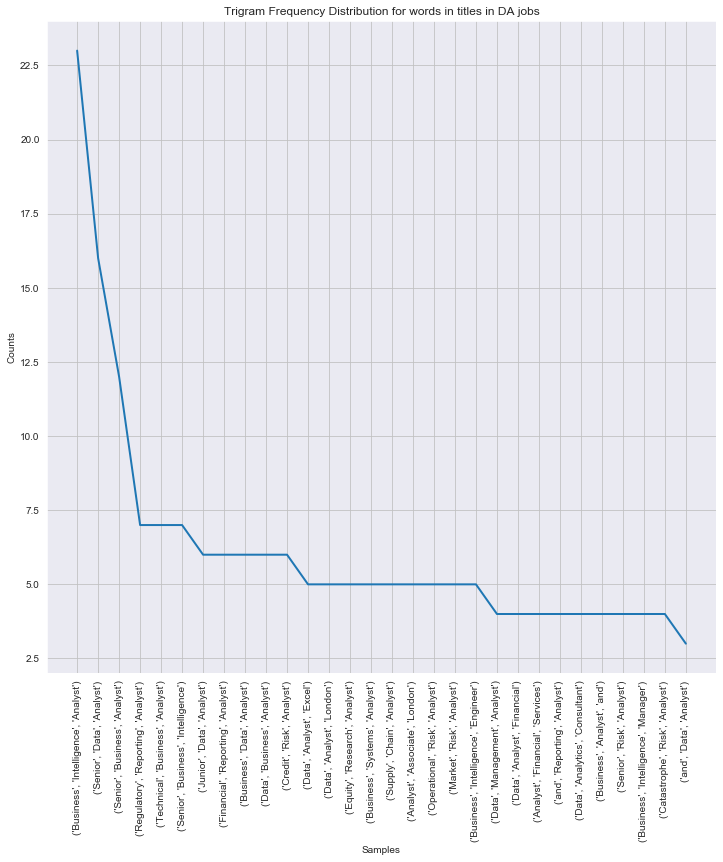

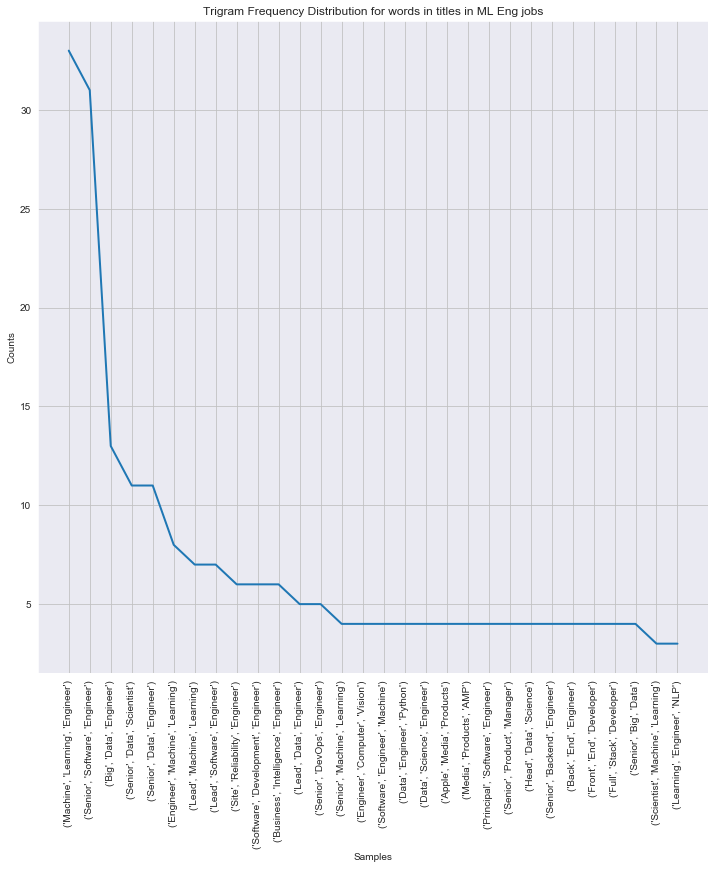

In [73]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, [], 'Trigram Frequency Distribution for words in titles in DS jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);
fn.plot_freqdist_from_series(df.loc[df.searched__data_analyst==1].job_title, tokenizer, [], 'Trigram Frequency Distribution for words in titles in DA jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);
fn.plot_freqdist_from_series(df.loc[df.searched__machine_learning_engineer==1].job_title, tokenizer, [], 'Trigram Frequency Distribution for words in titles in ML Eng jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);

Straight off the bat from looking at the distributions the severely positive skew in DS shows that we're reaching the end of informative ngrams here (at least without the stopword filtering). On the ML Eng side, it seems as if we're approaching niche terms, since individual companies ('Apple') are coming up. We've exhausted regular ngrams, but as a final step we want to check acronyms, since it's an industry domnated by them. 

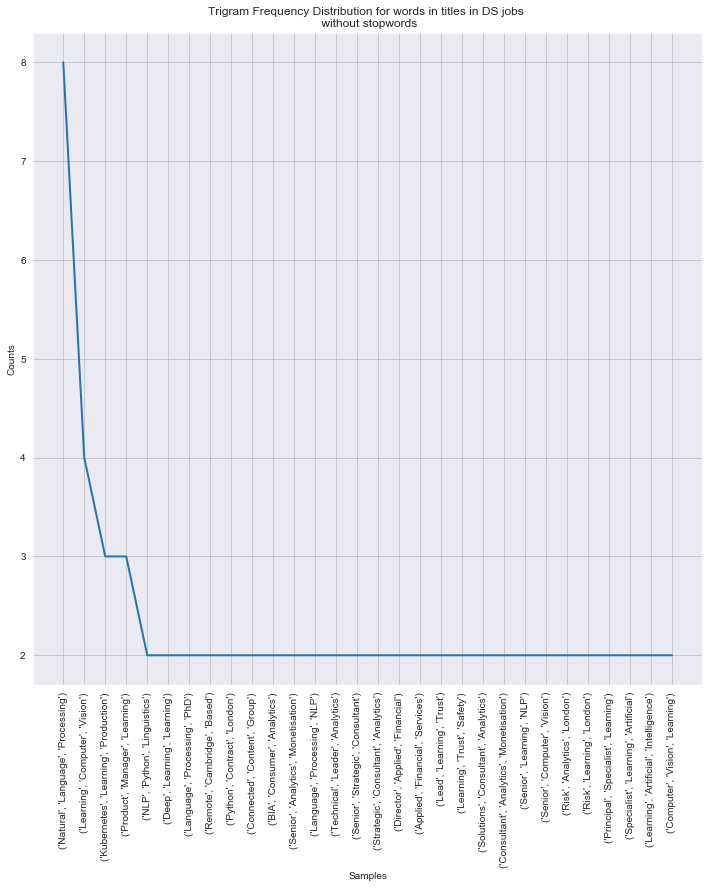

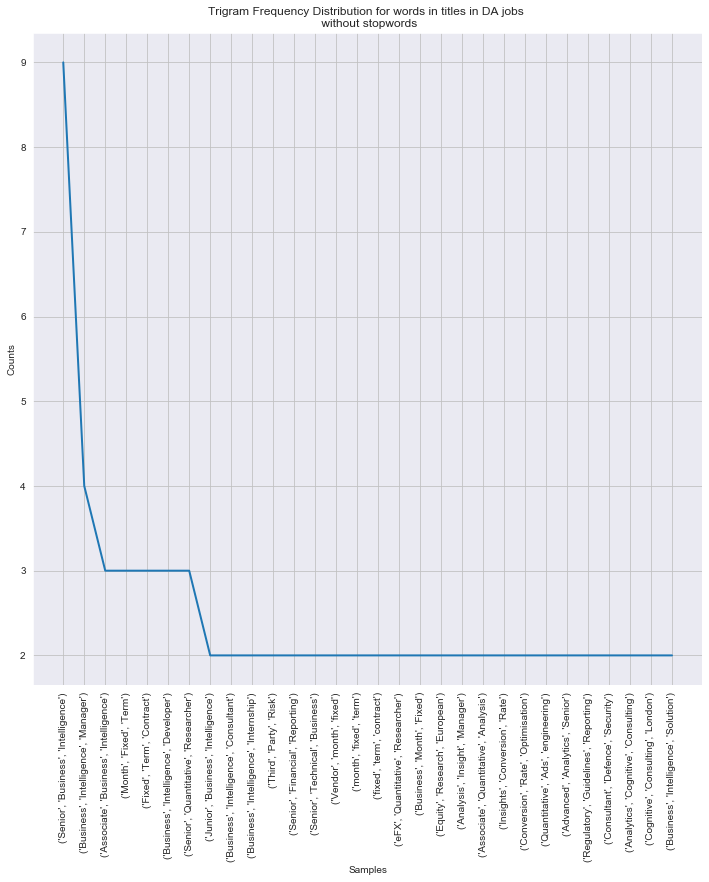

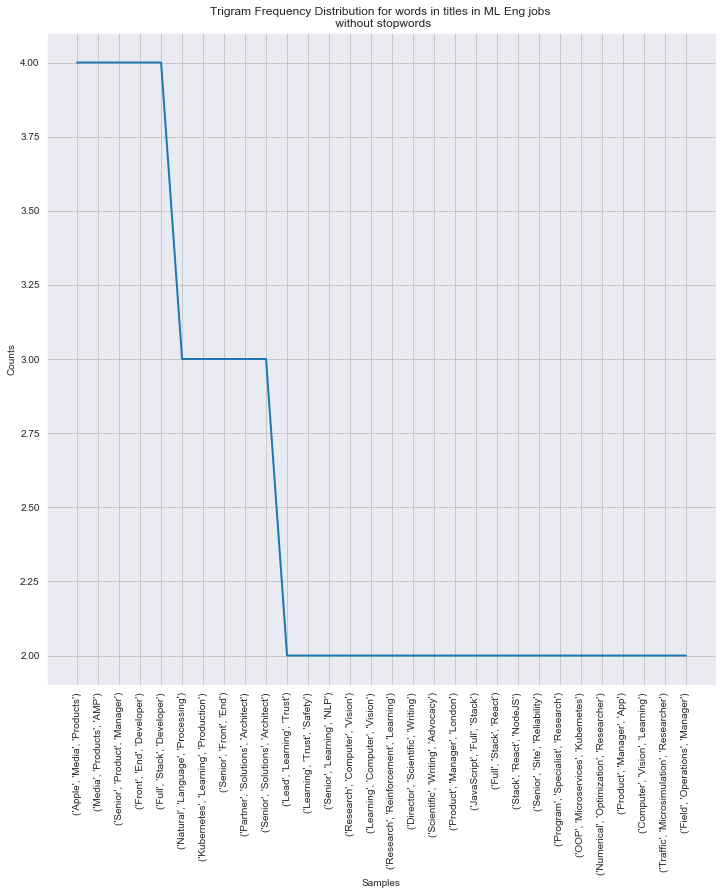

In [74]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, stop_word_lst, 'Trigram Frequency Distribution for words in titles in DS jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);
fn.plot_freqdist_from_series(df.loc[df.searched__data_analyst==1].job_title, tokenizer, stop_word_lst, 'Trigram Frequency Distribution for words in titles in DA jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);
fn.plot_freqdist_from_series(df.loc[df.searched__machine_learning_engineer==1].job_title, tokenizer, stop_word_lst, 'Trigram Frequency Distribution for words in titles in ML Eng jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);

And we can see now just how prevalent using the buzzword 'AI' is - not that much! The other terms mostly have such low frequencies that it's barely worth noting them - although this will change for them in the description fields (concerned about how 'PhD' is going to fare). 

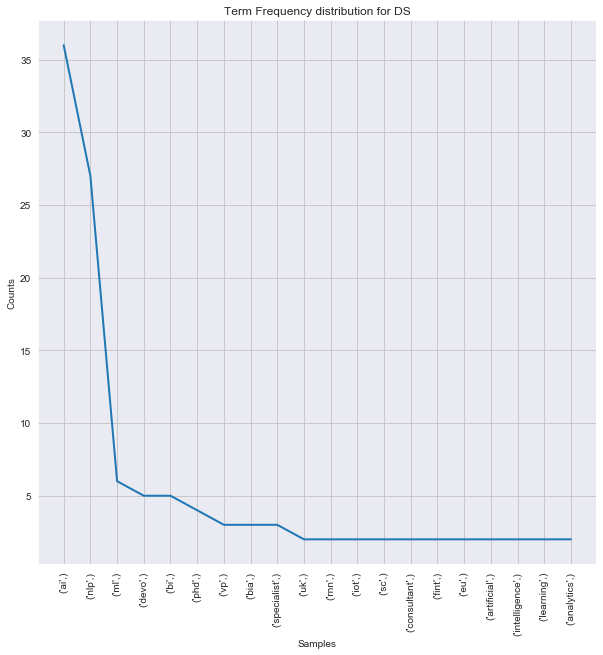

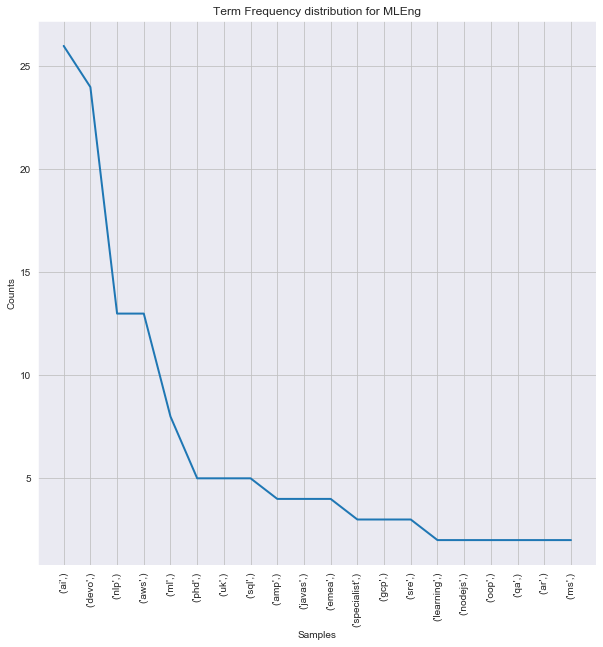

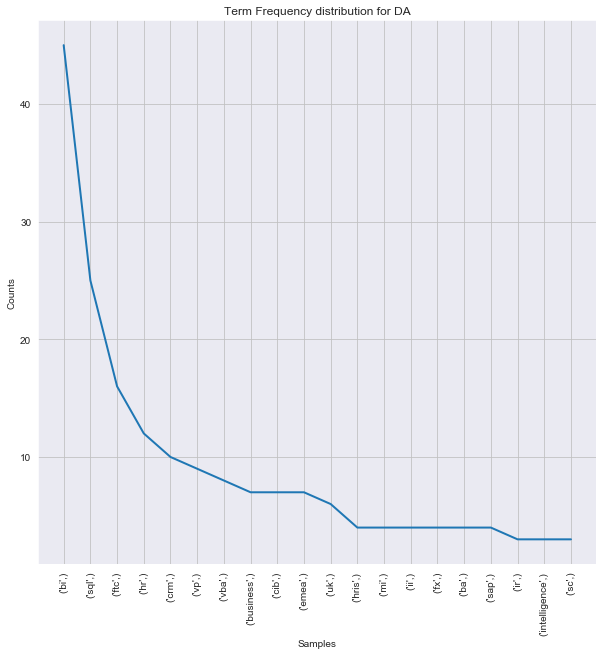

terms  freq_in_DS  freq_in_MLEng  freq_in_DA
0    (ai,)        36.0            NaN         NaN
1   (nlp,)        27.0            NaN         NaN
2    (ml,)         6.0            NaN         NaN
3  (devo,)         5.0            NaN         NaN
4    (bi,)         5.0            NaN         NaN

In [75]:
test_df = fn.get_top_n_df([df.loc[df.searched__data_scientist==1].job_title, 
                            df.loc[df.searched__machine_learning_engineer==1].job_title, 
                            df.loc[df.searched__data_analyst==1].job_title], ['DS', 'MLEng', 'DA'], 
                            RegexpTokenizer(r'[A-Z]+[a-zA-Z]*[A-Z]'),
                         stop_word_lst);
test_df.head()

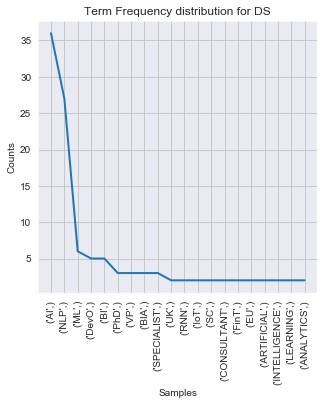

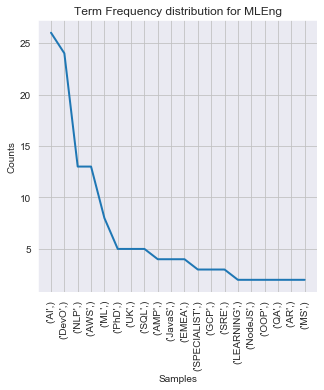

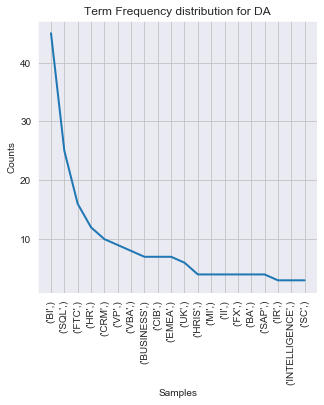

Index(['terms', 'freq_in_DS', 'freq_in_MLEng', 'freq_in_DA'], dtype='object')


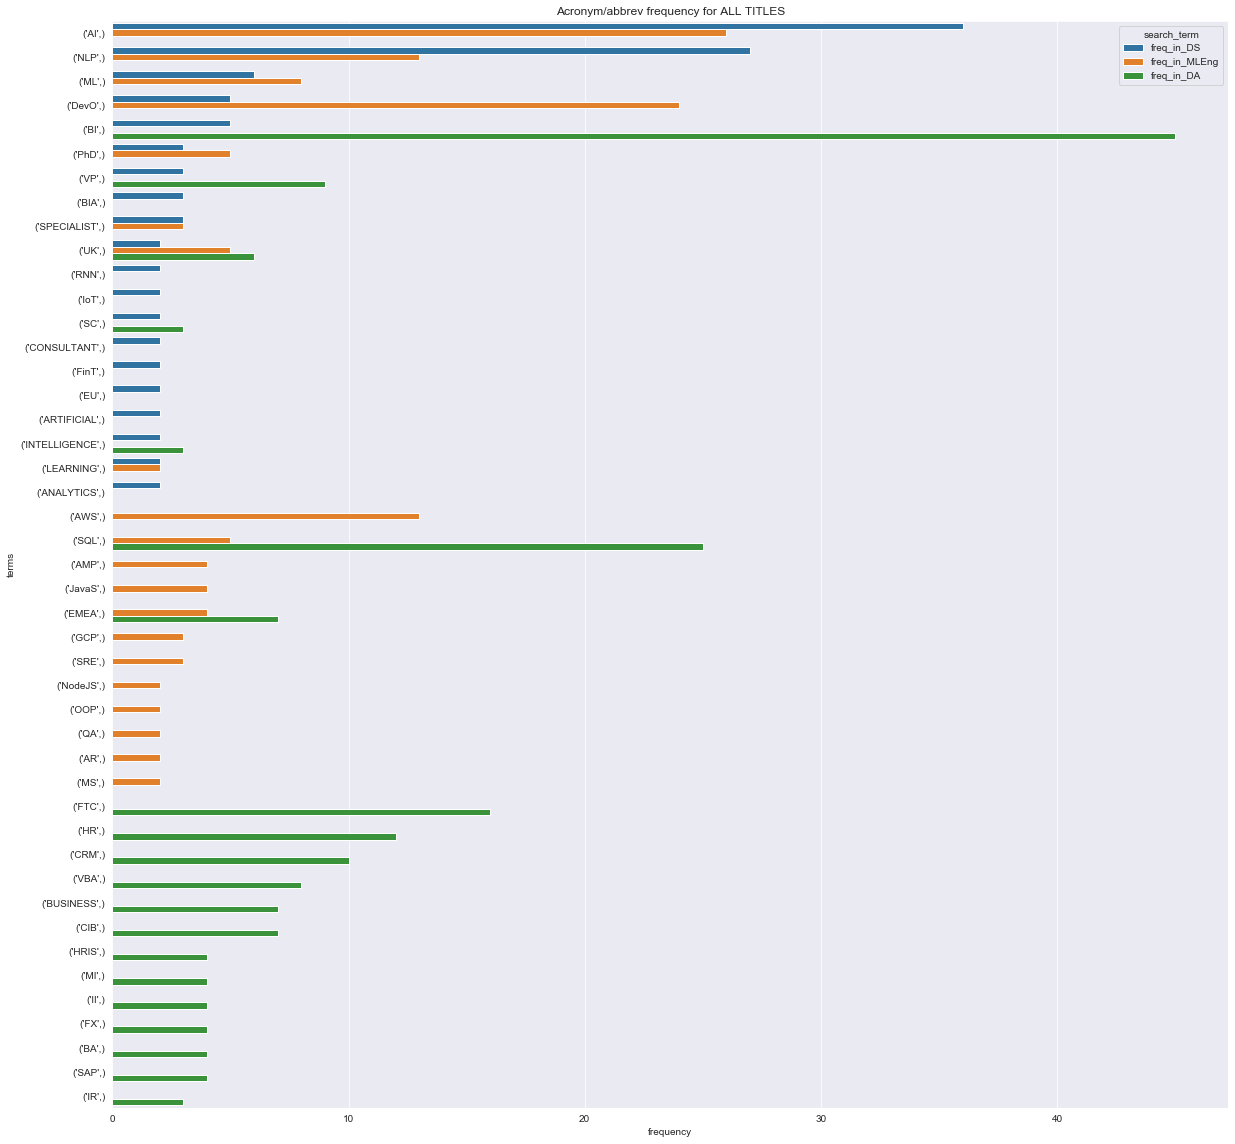

In [76]:

plot_df = fn.plot_term_bar('Acronym/abbrev frequency for ALL TITLES',
                           [df.loc[df.searched__data_scientist==1].job_title, 
                            df.loc[df.searched__machine_learning_engineer==1].job_title, 
                            df.loc[df.searched__data_analyst==1].job_title], 
                           ['DS', 'MLEng', 'DA'],
                          RegexpTokenizer(r'[A-Z]+[a-zA-Z]*[A-Z]'), stop_word_lst, 'Acronym/abbreviation Frequency Distribution for words in titles in ALL jobs',
                             figsize=(20,20), num_terms=20, lower_case=False, ngram_number=1, save_fig=True, save_fig_name='acronyms_across_ALL_TITLES')


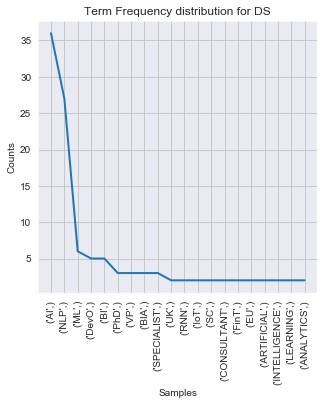

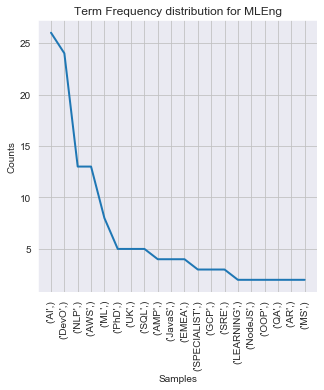

Index(['terms', 'freq_in_DS', 'freq_in_MLEng'], dtype='object')


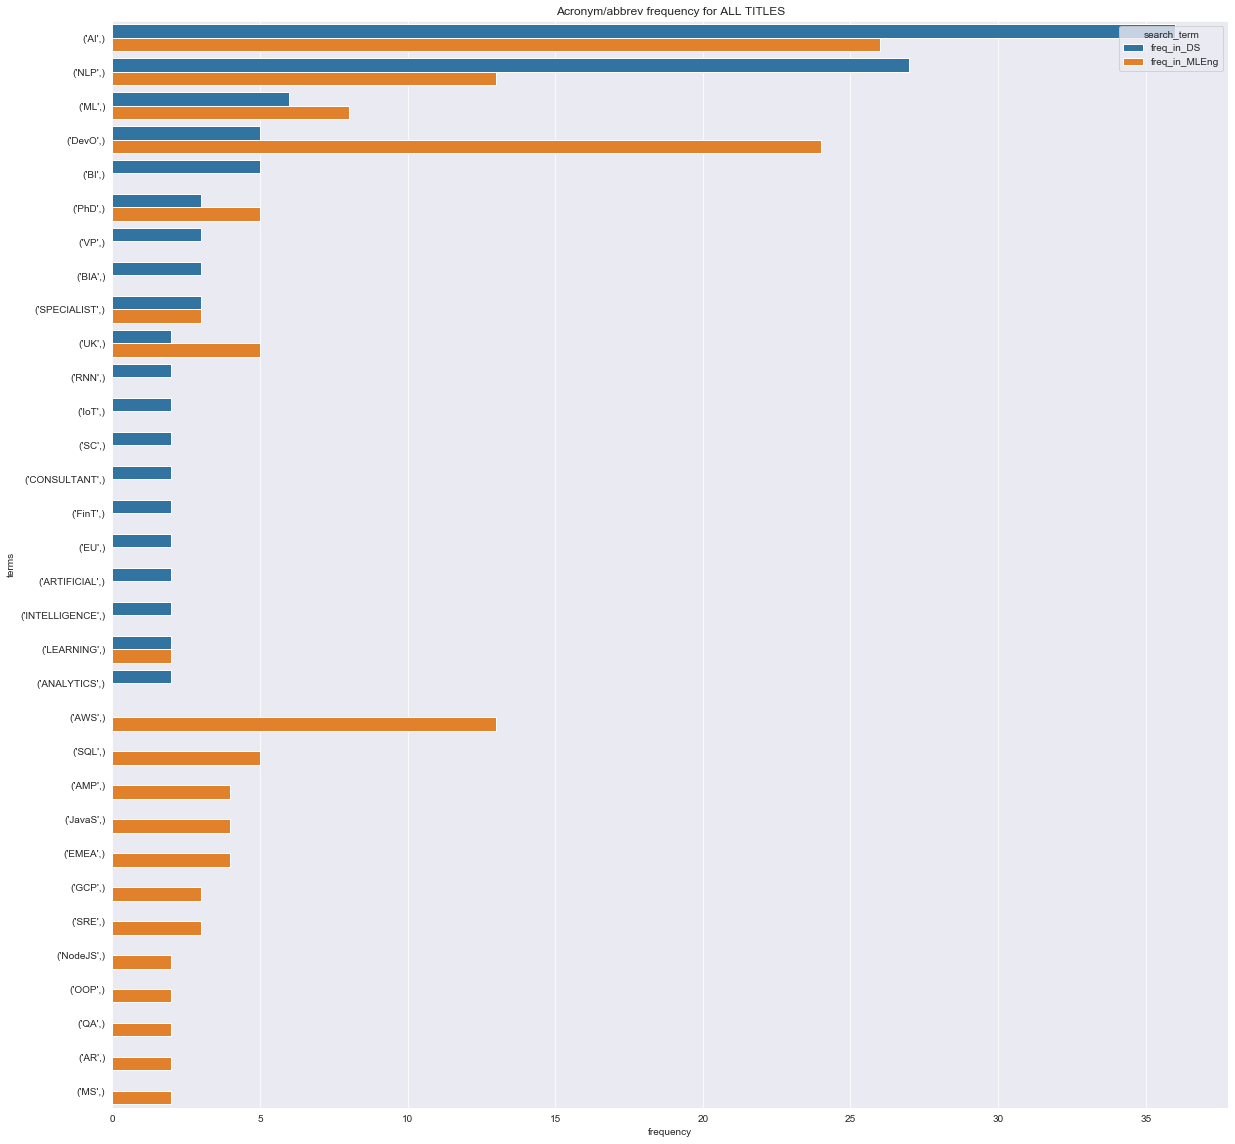

In [77]:
plot_df = fn.plot_term_bar('Acronym/abbrev frequency for ALL TITLES',
                           [df.loc[df.searched__data_scientist==1].job_title, 
                            df.loc[df.searched__machine_learning_engineer==1].job_title],
                           ['DS', 'MLEng'],
                          RegexpTokenizer(r'[A-Z]+[a-zA-Z]*[A-Z]'), stop_word_lst, 'Acronym/abbreviation Frequency Distribution for words in titles in DS and ML jobs',
                             figsize=(20,20), num_terms=20, lower_case=False, ngram_number=1, save_fig=True, save_fig_name='acronyms_across_DS_and_MLEng_TITLES')


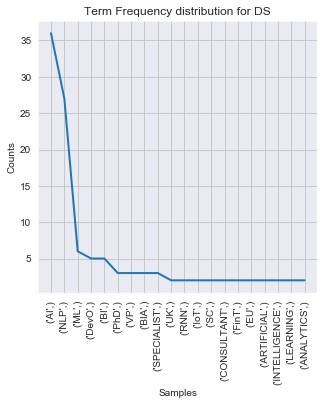

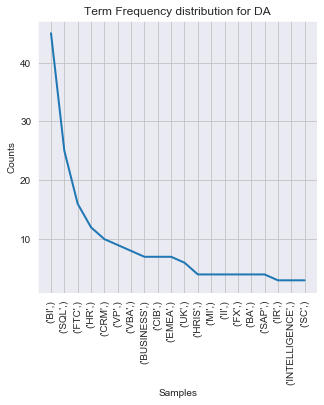

Index(['terms', 'freq_in_DS', 'freq_in_DA'], dtype='object')


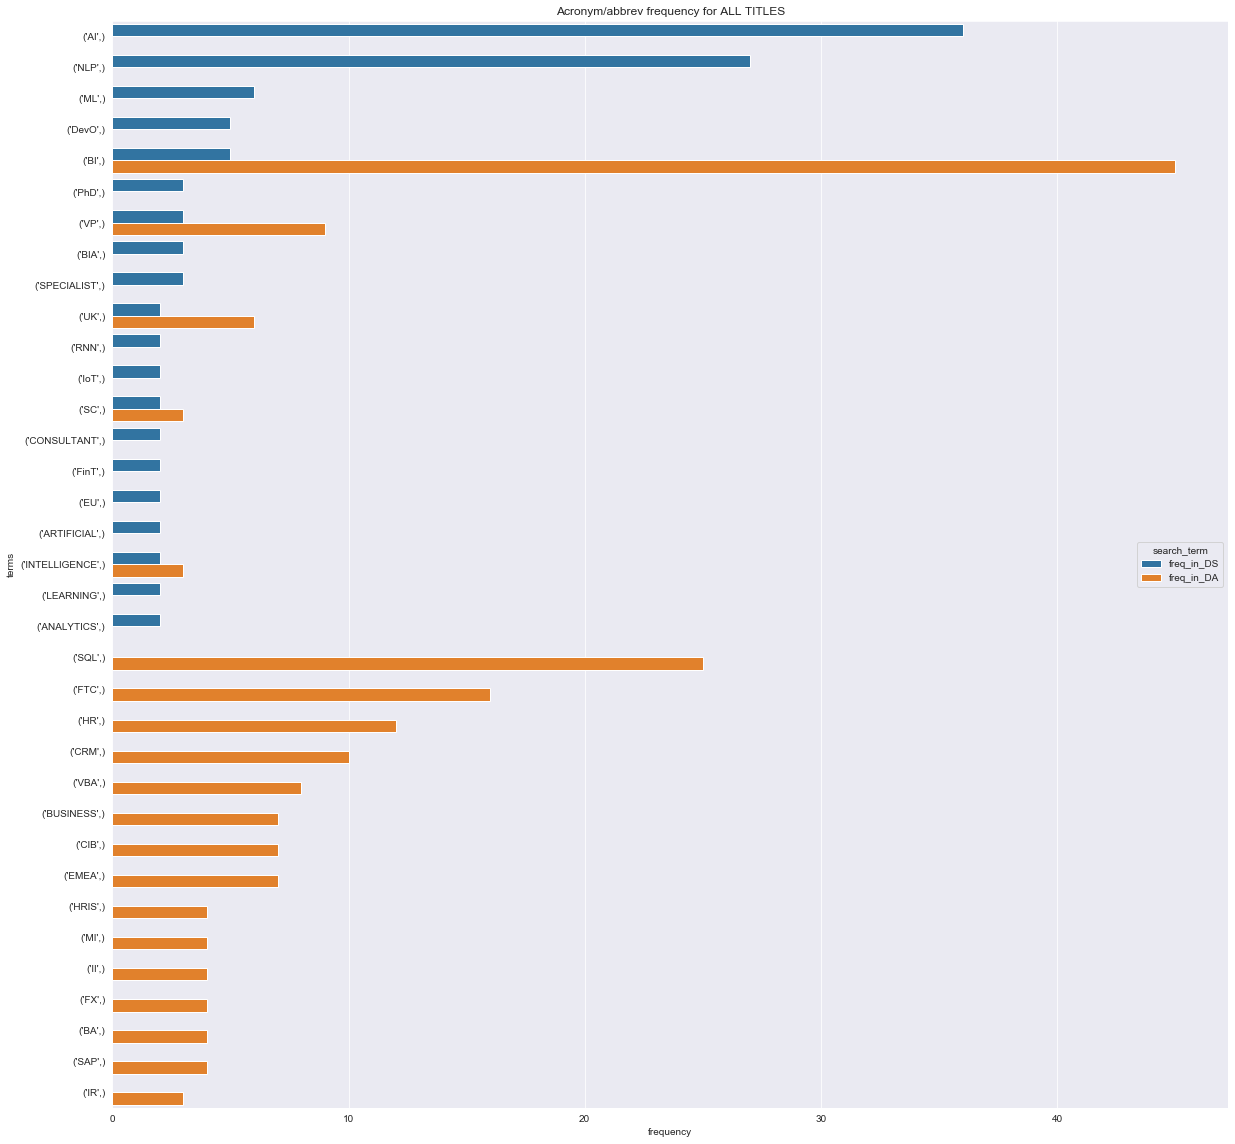

In [78]:
plot_df = fn.plot_term_bar('Acronym/abbrev frequency for ALL TITLES',
                           [df.loc[df.searched__data_scientist==1].job_title, 
                            df.loc[df.searched__data_analyst==1].job_title],
                           ['DS', 'DA'],
                          RegexpTokenizer(r'[A-Z]+[a-zA-Z]*[A-Z]'), stop_word_lst, 'Acronym/abbreviation Frequency Distribution for words in titles in DS and DA jobs',
                             figsize=(20,20), num_terms=20, lower_case=False, ngram_number=1, save_fig=True, save_fig_name='acronyms_across_DS_and_DA_TITLES')


In [79]:
plot_df.search_term.value_counts()

freq_in_DS    40
freq_in_DA    40
Name: search_term, dtype: int64

And finally, because we're sick of frequency distribution graphs, when we plot word clouds, we see the same trends - 'Senior' features more heavily in ML jobs --> it would be interesting to explore whether salaries also reflect this (see section 3 for more info).

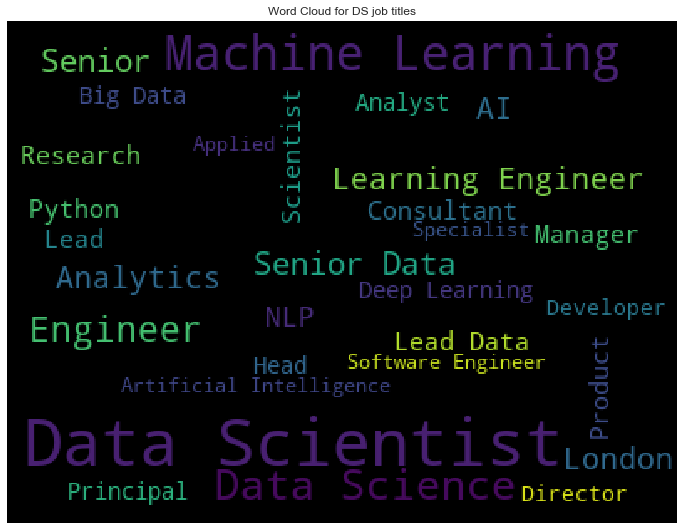

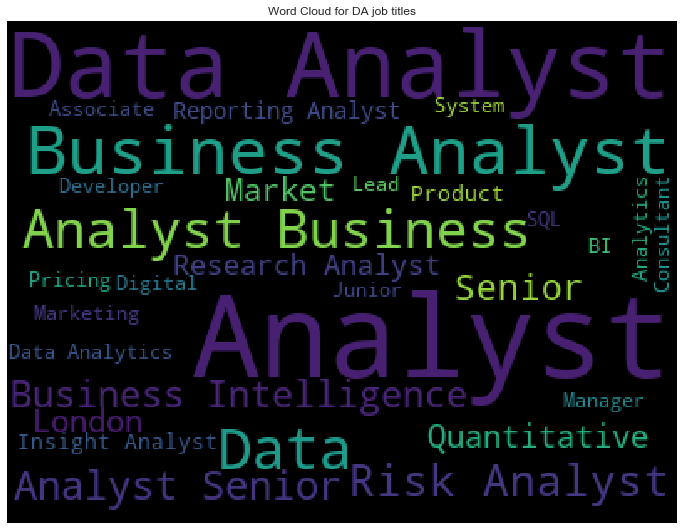

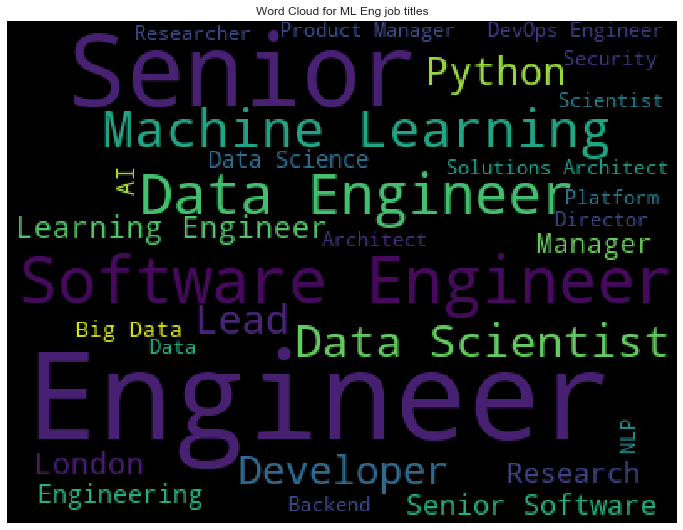

In [80]:
fn.gen_cloud(df.loc[df.searched__data_scientist==1].job_title, 30, cloud_title='Word Cloud for DS job titles')
fn.gen_cloud(df.loc[df.searched__data_analyst==1].job_title, 30, cloud_title='Word Cloud for DA job titles')
fn.gen_cloud(df.loc[df.searched__machine_learning_engineer==1].job_title, 30, cloud_title='Word Cloud for ML Eng job titles')

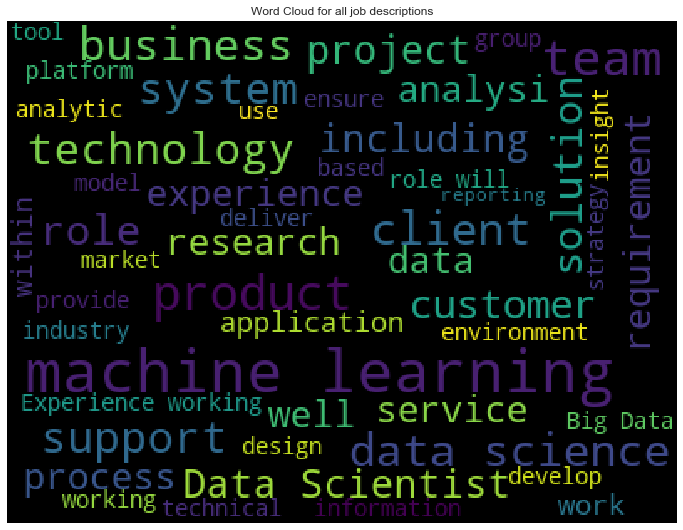

In [81]:
fn.gen_cloud(df.job_descr, 50, cloud_title='Word Cloud for all job descriptions')

<a id=one ><a/> 

## 2. Text EDA of the three categories
    
[LINK to table of contents](#contents)

Now we get into the meat of the text - the job descriptions. I've done the same exploration as for titles in the same order, except I've filtered out stopwords more frequently, due to the nature of the description text. 

Most surprising is how often 'team' comes up and perhaps this reflects the need for DS's and MLEng's to work together and operate well with other employees. 

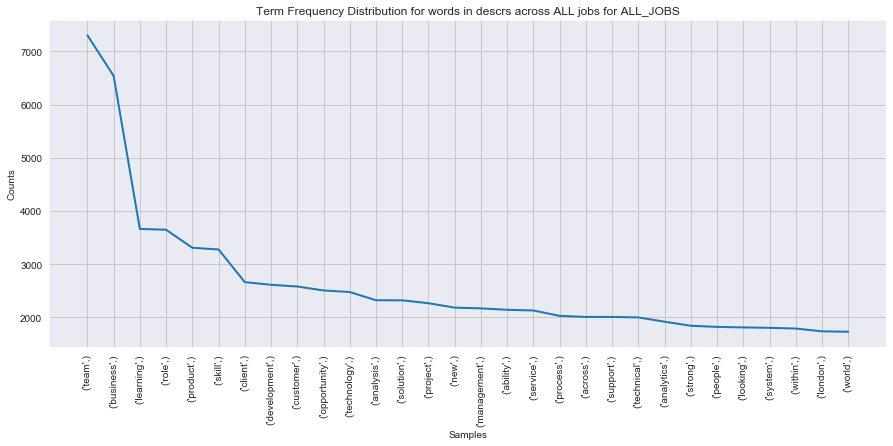

Text(0.5, 1.0, 'Terms across both jobs')

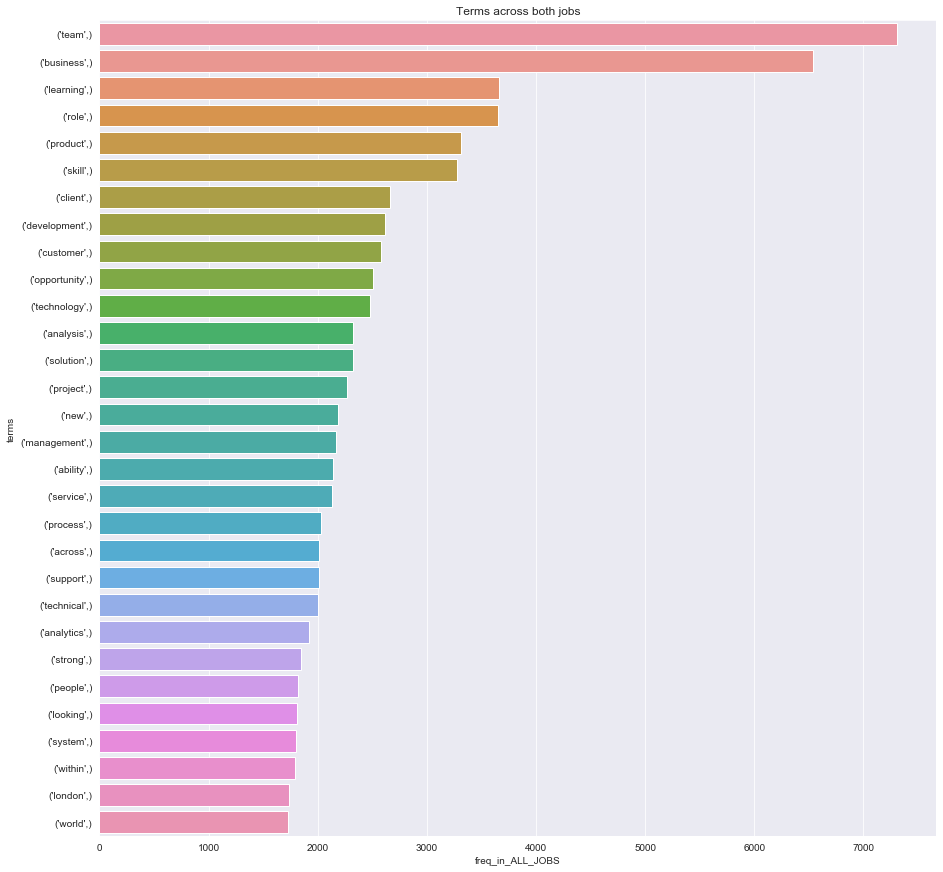

In [82]:
plot_df = fn.get_top_n_df([df.job_descr],['ALL_JOBS'], tokenizer, stop_word_lst, 'Term Frequency Distribution for words in descrs across ALL jobs',
                             figsize=(15,6), num_terms=30, lower_case=True, ngram_number=1);

plt.figure(figsize=(15,15))
plot = sns.barplot(y = 'terms', x = 'freq_in_ALL_JOBS', data=plot_df)  
plt.title('Terms across both jobs')

The bigrams we're seeing are a lot less frequent than the previous single terms, however quick inspection shows that a lot of them are the type we'd only see mentioned once in a job post - e.g. 'day holiday', 'around world' - over 10% of the job posts give an indication that the employers (or at the very least the HR teams that wrote these) seem to show off grandiose ambitions or want to be seen as globally competitive organisations with the staff to reflect that. 
At this point we can detect more interesting patterns in how companies market their job posts regarding equal employment. For instance:
 * 'sexual orientation' undoubtedly comes from the paragraph at the bottom of most posts where companies promote themselves as an equal opportunity employer - it's only registering at around 140, less than 15% of job posts
 * 'equal opportunity' similarly only comes in about 125 times in this list - the majority of jobs aren't advertising themselves as that. 
 
An important thing to note that a company that DOES promote itself as this doesn't *necessarily* follow through on that AND vice versa, that a company not advertising themselves as such, isn't an unfair employeer. If you want to look at a more indicative measure of how many employeers are fair based on an arguably more objective metric, please go to section 3. 

What this does indicate is that the majority of DS and MLeng jobs aren't seeing that as an important thing to mention in their job posts. This could be for a variety of reasons - e.g. being fair and undiscriminatory in hiring practices is already the _law_; it could be that some companies aren't that great at fair hiring practices; could be that some companies see it as a waste of text because actions speak louder than filler text copied from an HR template. We can't assume anything here, only that the writers of these posts _mostly_ choose not to include those kind of statements. 

Another noteworthy bigram is 'flexible working' appearing in just under 19% of job posts - if around 1 in 5 jobs ONLY mentions that (and we see no mention of 'remote work') then how much has the job market changed for these jobs post-lockdown? How much do they accommodate those who need flexible working?

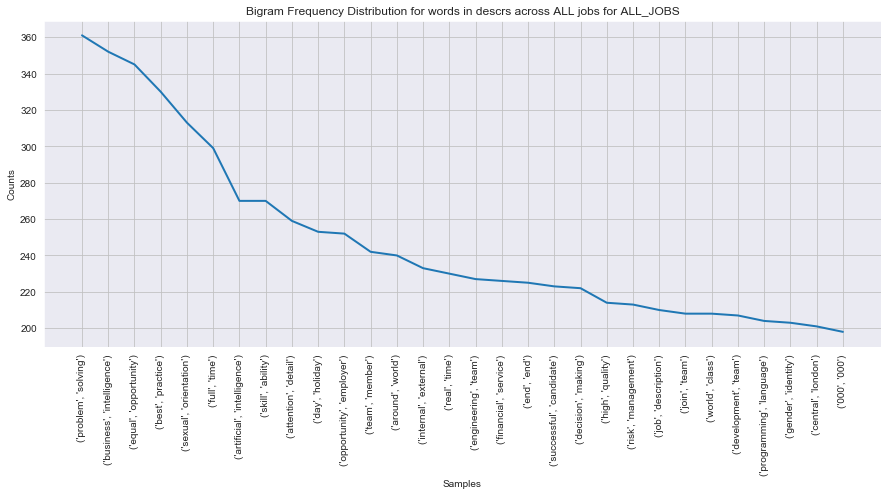

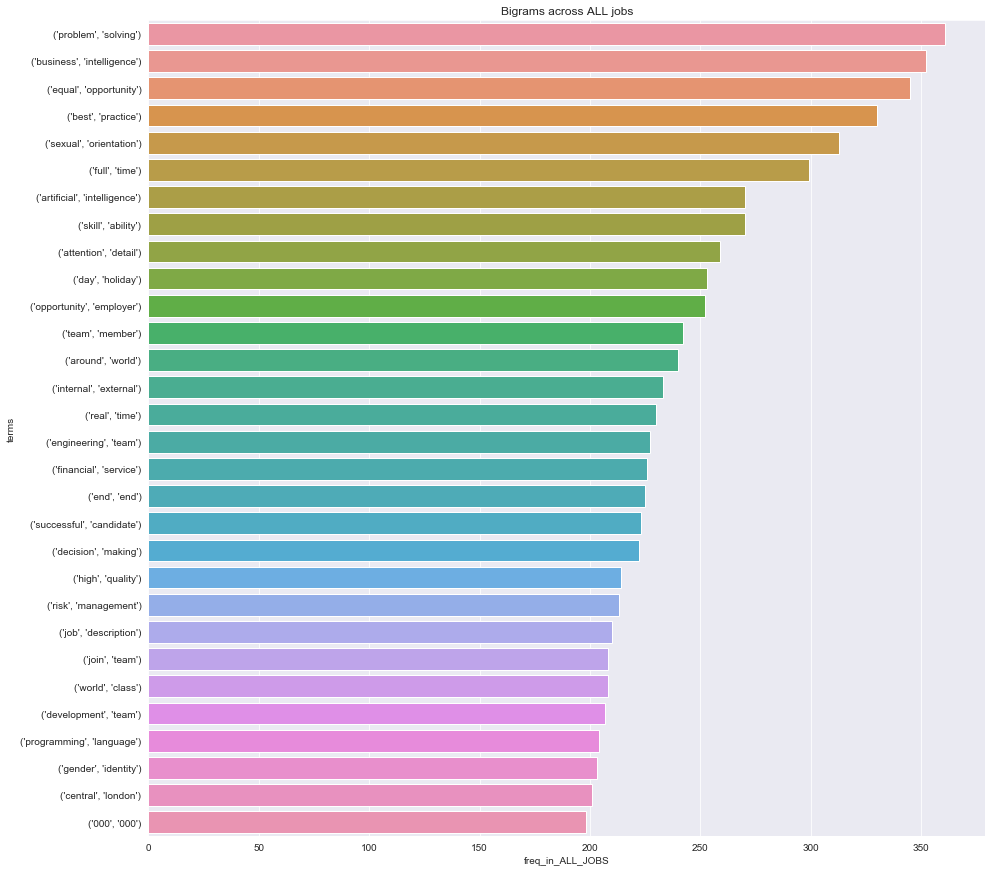

In [212]:
plot_df = fn.get_top_n_df([df.job_descr],['ALL_JOBS'], tokenizer, stop_word_lst, 'Bigram Frequency Distribution for words in descrs across ALL jobs',
                             figsize=(15,6), num_terms=30, lower_case=True, ngram_number=2);

plt.figure(figsize=(15,15))
plot = sns.barplot(y = 'terms', x = 'freq_in_ALL_JOBS', data=plot_df )  
plt.title('Bigrams across ALL jobs');

As noted above, the equal employer flags do come up across a lot of job posts, but still it's just less than 10% of job posts, for potential reasons we discussed above. 
It's more interesting to note that AWS and NLP are finally coming up, in about 11-12% of job descriptions. The majority of jobs just aren't that concerened with those topics. Let's plot this again WITH the industry stopwords and see if we can catch more info. 

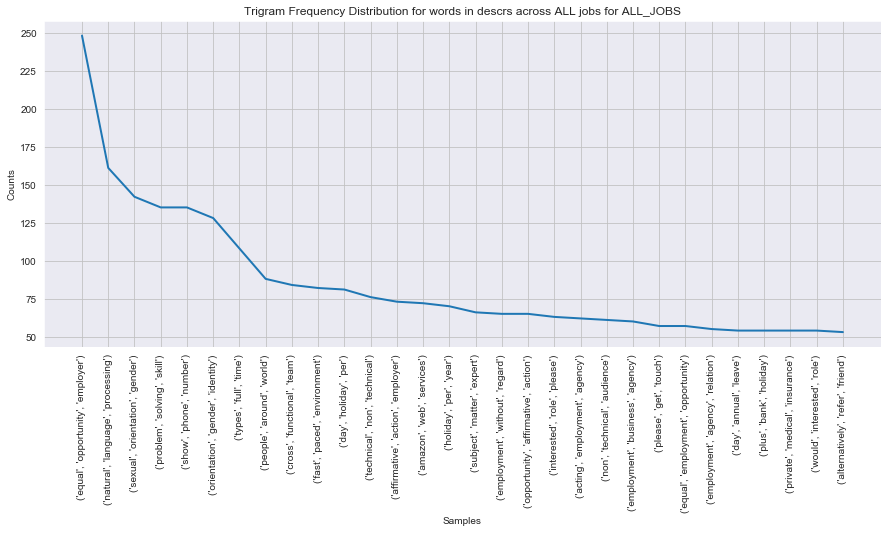

Text(0.5, 1.0, 'Trigrams across ALL jobs')

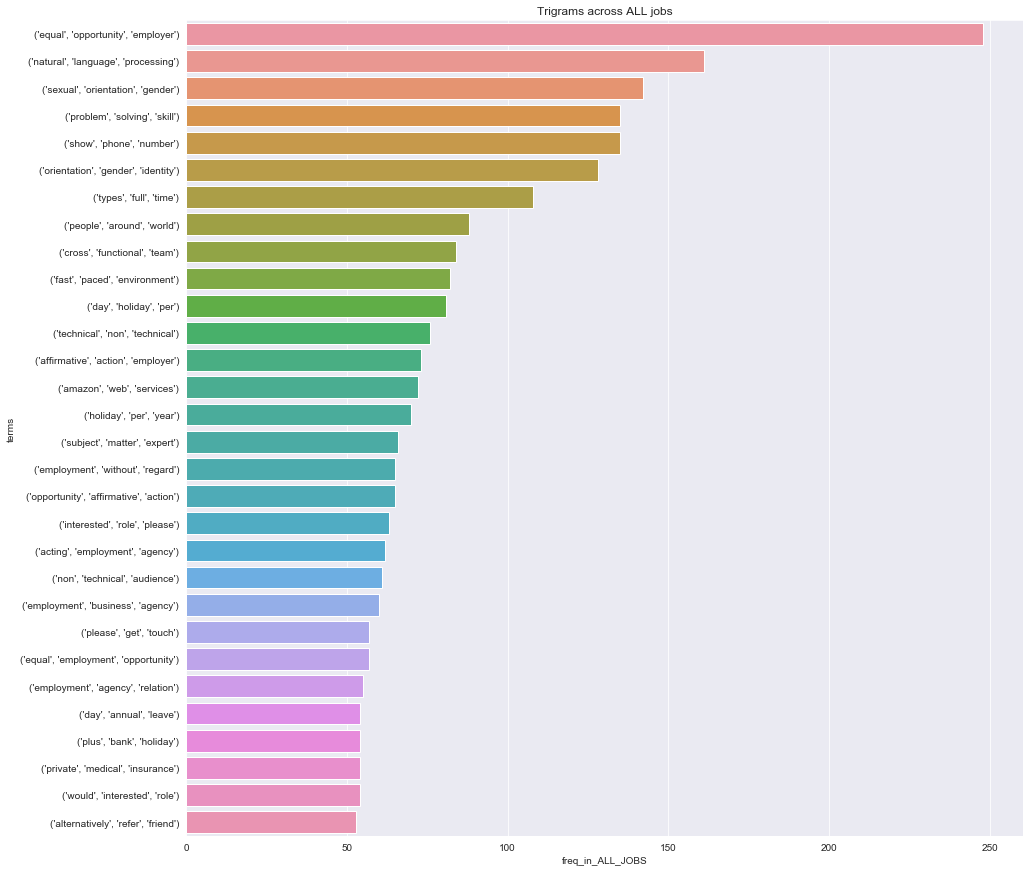

In [213]:
plot_df = fn.get_top_n_df([df.job_descr],['ALL_JOBS'], tokenizer, stop_word_lst, 'Trigram Frequency Distribution for words in descrs across ALL jobs',
                             figsize=(15,6), num_terms=30, lower_case=True, ngram_number=3);

plt.figure(figsize=(15,15))
plot = sns.barplot(y = 'terms', x = 'freq_in_ALL_JOBS', data=plot_df )  
plt.title('Trigrams across ALL jobs')

The picture doesn't change that much, with ML models getting mentioned ~140 times. We should move to separate distributions for our job types and for acronyms/abbreviations.

In [214]:
print('Total DS jobs     = ', len(df.loc[df.searched__data_scientist==1].job_descr))
print('Total DA jobs     = ', len(df.loc[df.searched__data_analyst==1].job_descr))
print('Total ML Eng jobs = ', len(df.loc[df.searched__machine_learning_engineer==1].job_descr))

Total DS jobs     =  545
Total DA jobs     =  986
Total ML Eng jobs =  680


We can see that the team-work factor is still significant in both job posts. What about bigrams?

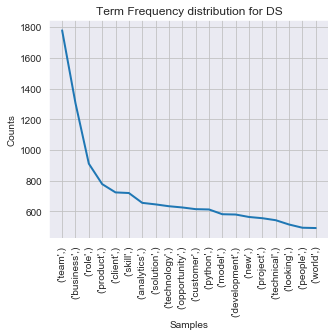

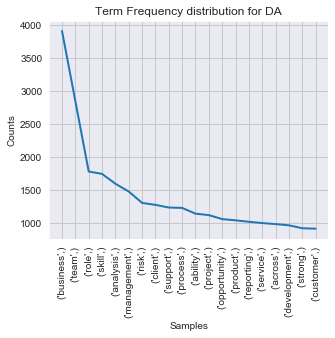

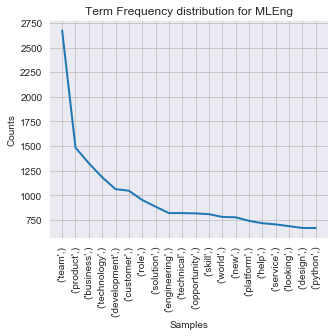

Index(['terms', 'freq_in_DS', 'freq_in_DA', 'freq_in_MLEng'], dtype='object')


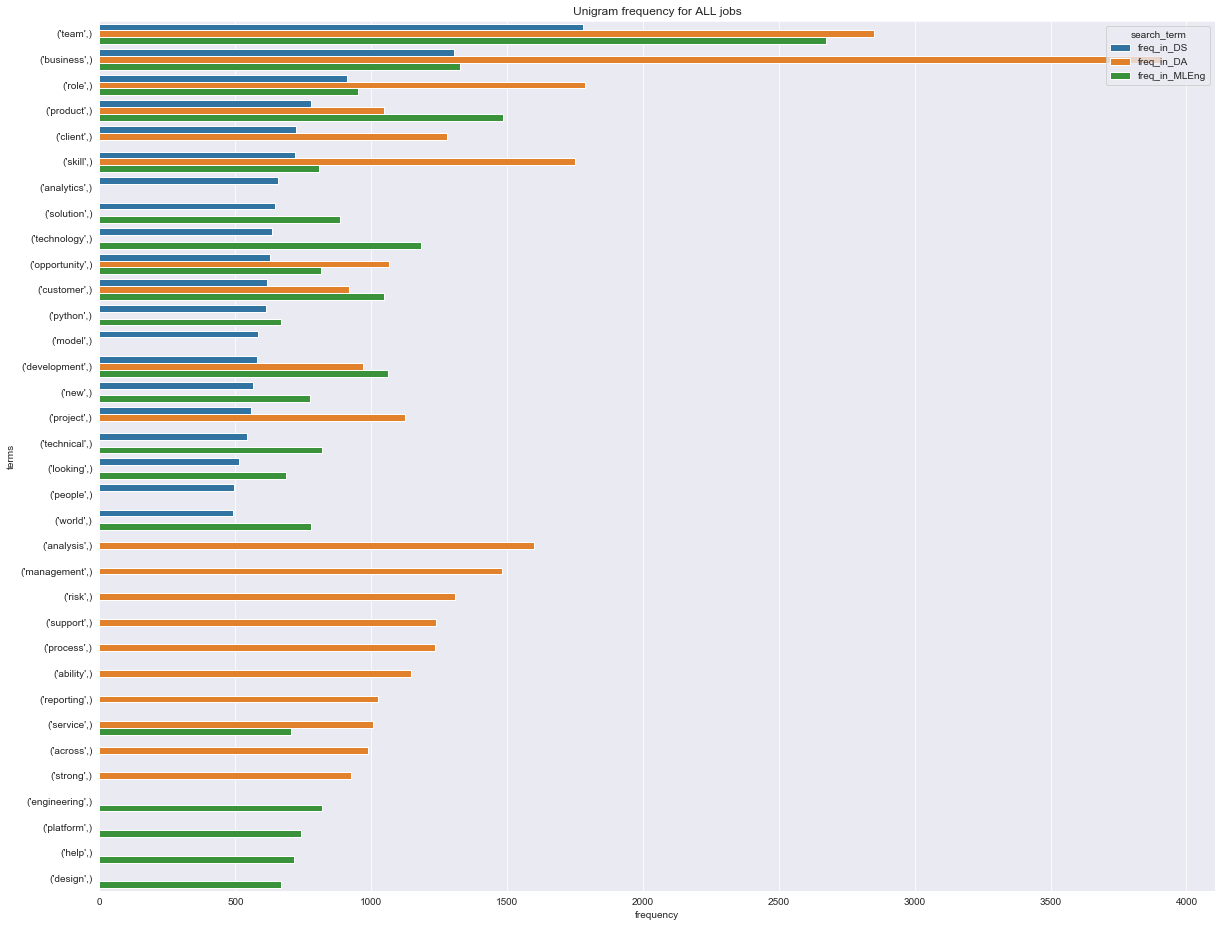

In [215]:
unigram_df = fn.plot_term_bar('Unigram frequency for ALL jobs',
                           [df.loc[df.searched__data_scientist==1].job_descr, 
                            df.loc[df.searched__data_analyst==1].job_descr, 
                            df.loc[df.searched__machine_learning_engineer==1].job_descr ], 
                              ['DS','DA', 'MLEng',],
                          tokenizer, stop_word_lst, 'Unigram Frequency Distribution for words in descrs in DS jobs w/out industry stopwords',
                             figsize=(20,16), num_terms=20, lower_case=True, ngram_number=1, save_fig=True, save_fig_name='unigrams_across_ALL_jobs')


The two categories diverge slightly here, with ML Eng having a stronger emphasis on 'best practice', 'large scale' and 'end \[to\] end' work. Both DS and DA feature AI, although ML Eng slightly more. There are fewer clearer patterns across DS. 

Let's try this again with the industry stopwords included.

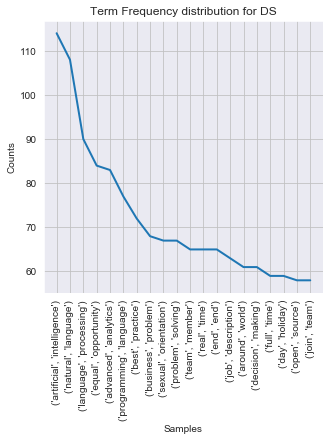

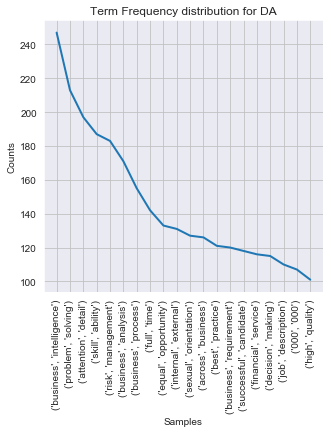

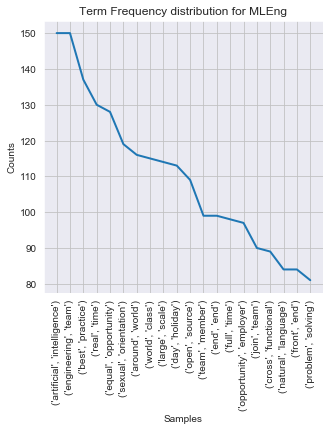

Index(['terms', 'freq_in_DS', 'freq_in_DA', 'freq_in_MLEng'], dtype='object')


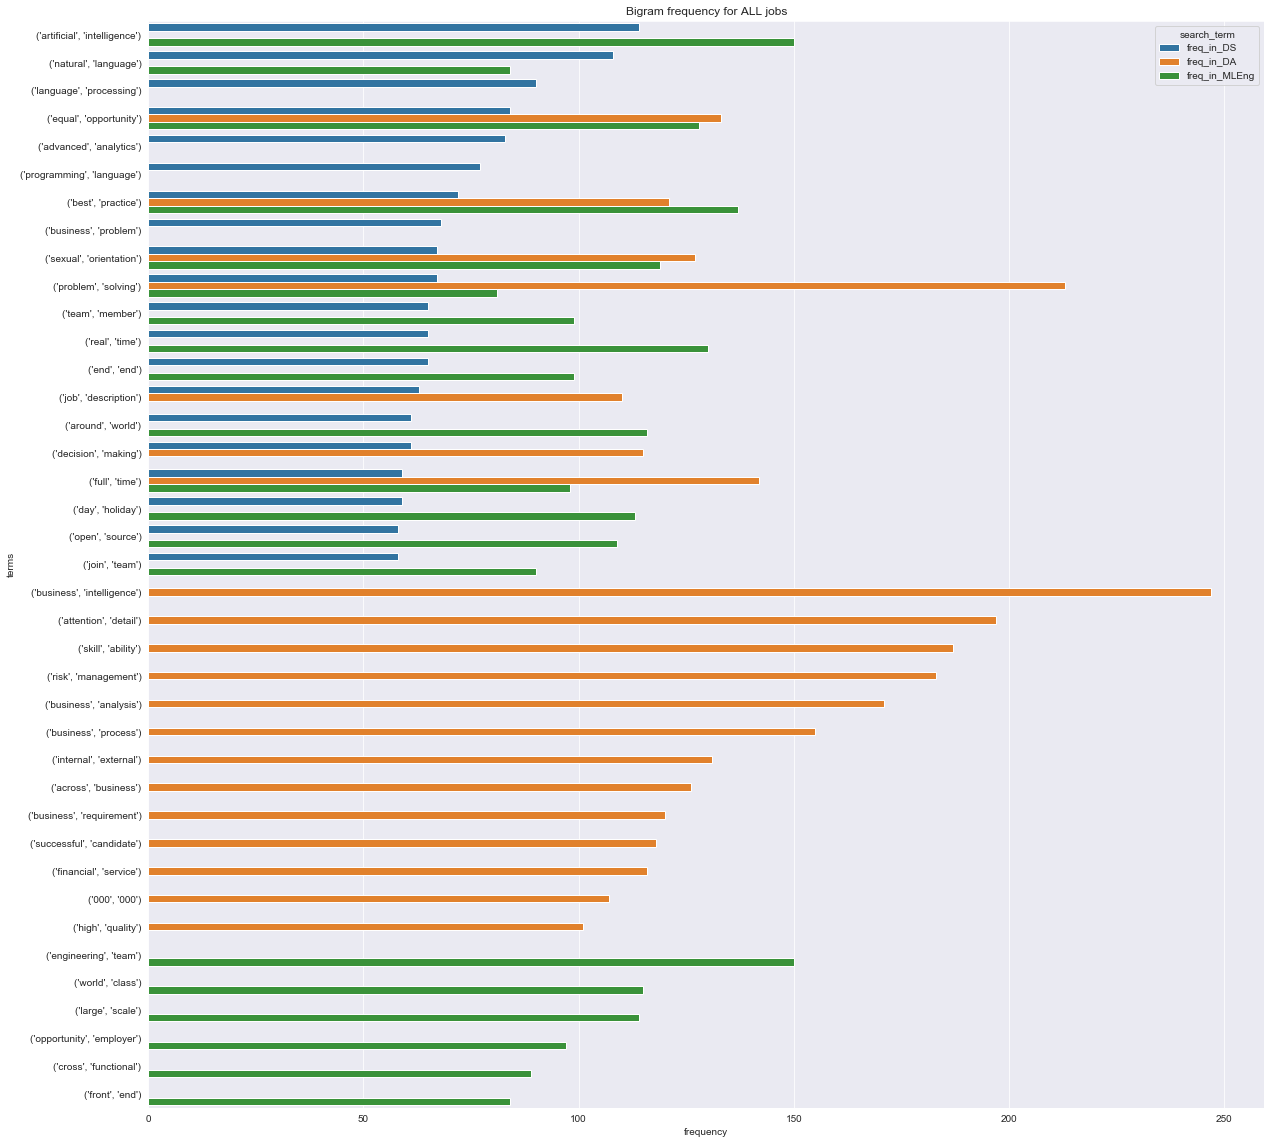

In [216]:
bigram_df = fn.plot_term_bar('Bigram frequency for ALL jobs',
                           [df.loc[df.searched__data_scientist==1].job_descr, 
                            df.loc[df.searched__data_analyst==1].job_descr,
                            df.loc[df.searched__machine_learning_engineer==1].job_descr], 
                             ['DS', 'DA','MLEng'],
                          tokenizer, stop_word_lst, 
                             'Bigram Frequency Distribution for words in descrs in ALL jobs w/ industry stopwords',
                             figsize=(20,20), num_terms=20, 
                             lower_case=True, ngram_number=2, 
                             save_fig=True, save_fig_name='fig/acronyms_across_ALL_jobs_with_stopws')

Putting industry stopwords back in has shown us :
* that it was a good idea to filter them out first (so many buzzwords, so little information) and
* that both types of job regularly involve using machine learning

It's surprising that 'deep learning' appears at similar frequencies in both types. This could be further speaking to the fact that the jobs have significant overlap. Onto trigrams!

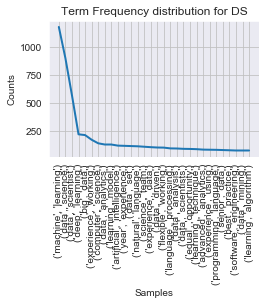

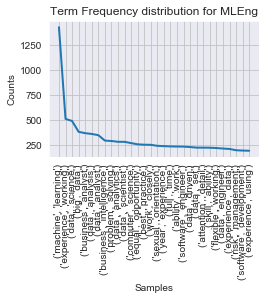

Index(['terms', 'freq_in_DS', 'freq_in_MLEng'], dtype='object')


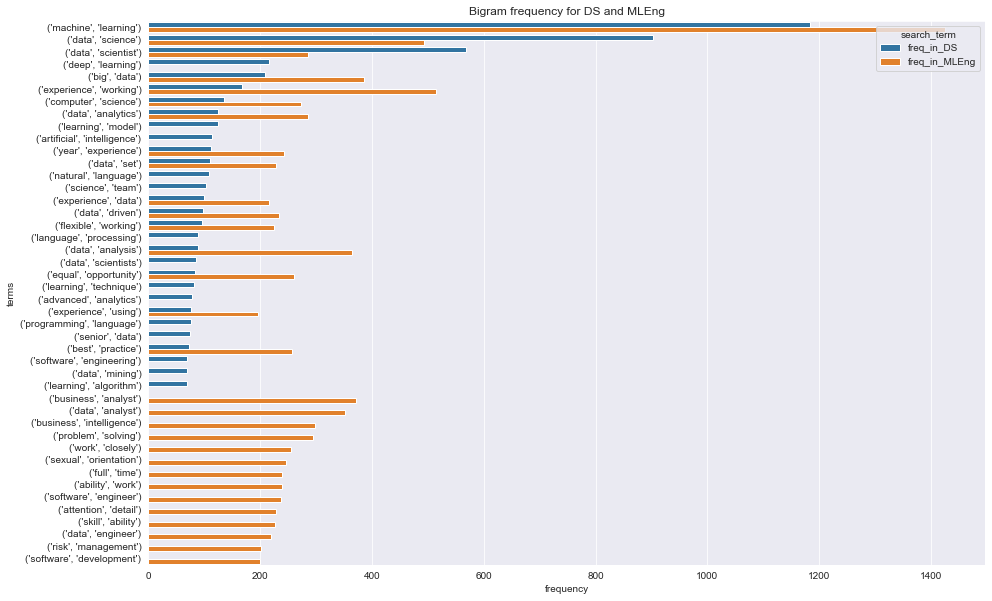

In [217]:
bigram_df = fn.plot_term_bar('Bigram frequency for DS and MLEng',
                           [df.loc[df.searched__data_scientist==1].job_descr, df.loc[df.searched__data_scientist==0].job_descr], ['DS', 'MLEng'],
                          tokenizer, stop_words, 'Bigram Frequency Distribution for words in descrs in DS jobs with industry stopwords',
                             figsize=(15,10), num_terms=30, lower_case=True, ngram_number=2, save_fig=True, save_fig_name='bigrams_across_ds_and_ml_wsws')

Straight off the bat from looking at the distributions we can see that the frequencies we're talking are moderately low, with the highest terms in both categoies only registering at about 15-20% and these being quite generic terms, like 'machine learning model'. At least that's a consistent trend in both categories. What about acronyms and abbreviations?

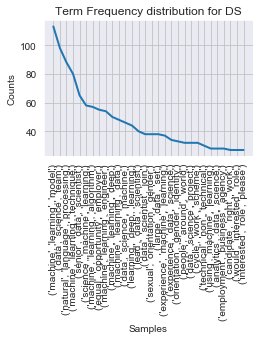

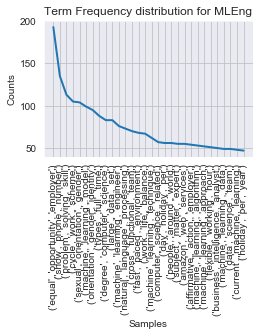

Index(['terms', 'freq_in_DS', 'freq_in_MLEng'], dtype='object')


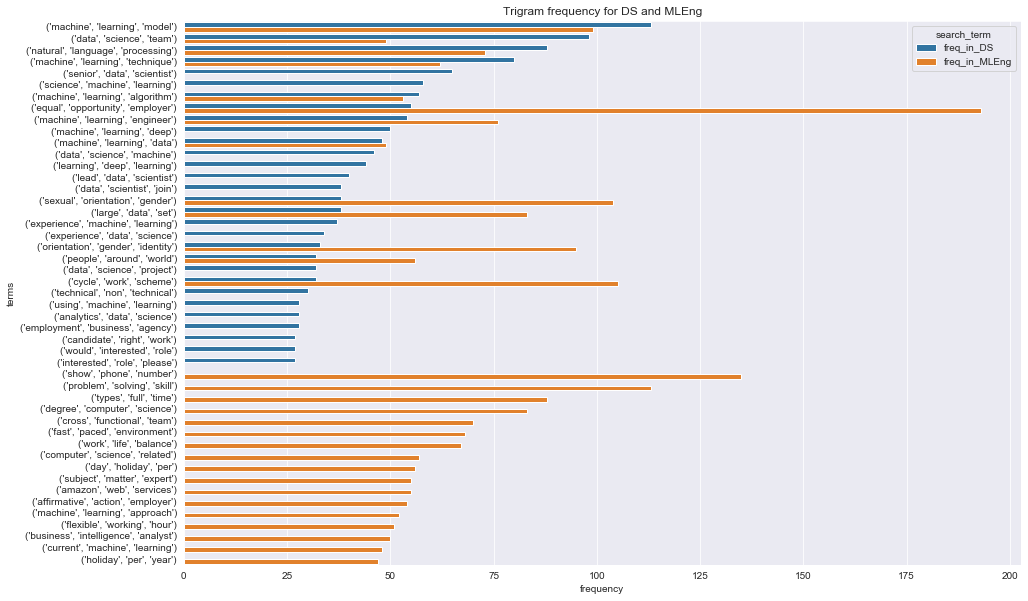

In [218]:
trigram_df = fn.plot_term_bar('Trigram frequency for DS and MLEng',
                           [df.loc[df.searched__data_scientist==1].job_descr, df.loc[df.searched__data_scientist==0].job_descr], ['DS', 'MLEng'],
                          tokenizer, stop_words, 'Acronym/abbreviation Frequency Distribution for words in descrs in DS jobs',
                             figsize=(15,10), num_terms=30, lower_case=True, ngram_number=3, save_fig=True, save_fig_name='bigrams_across_ds_and_ml')


Now we're getting some more useful insight. 
* For a start, SQL is comparatively equal in both categories, i.e. around 40-45% of the data (assuming it's mentioned once per job post - and generally job posts don't have much reason to state it more than twice, but we can investigate that later). 
* If you're looking for DS jobs you'll benefit from cloud platform experience, what with AWS and GCP coming up, HOWEVER if you're looking for ML Eng jobs you've VERY likely to be using / needing AWS, as it occurs over 600 times. We'll check later how often that actually is without repeats in the same job post, but it's a good start for further exploration. 
* NLP is almost twice as frequently mentioned in DS than in ML Eng - guess I won't be building NLP pipelines any time soon! It's hard to draw conclusions from this, but it's interesting that this occurs. Perhaps it'll come up again in later analysis.
* You'd suspect the ML Jobs might have to focus more on data extraction and databases, but the occurence of terms like 'NoSQL', 'ETL' and 'SQL' appearing similar (within 5% points) relative amounts makes doubt that presupposition. Having said that, remember that there also jobs that contain both data science and ML elements, partly because some companies advertise for both simultaneously. 

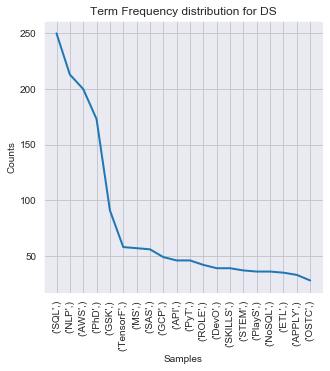

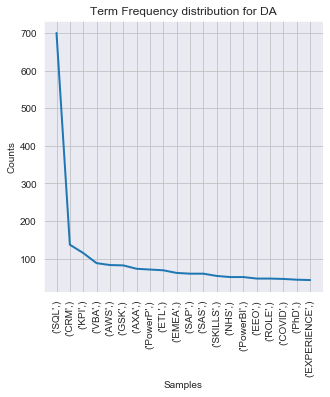

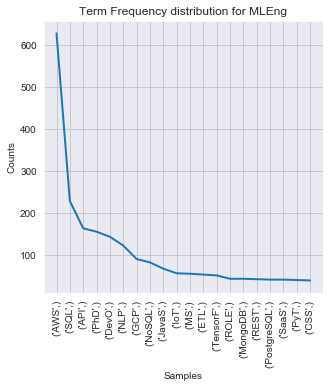

Index(['terms', 'freq_in_DS', 'freq_in_DA', 'freq_in_MLEng'], dtype='object')


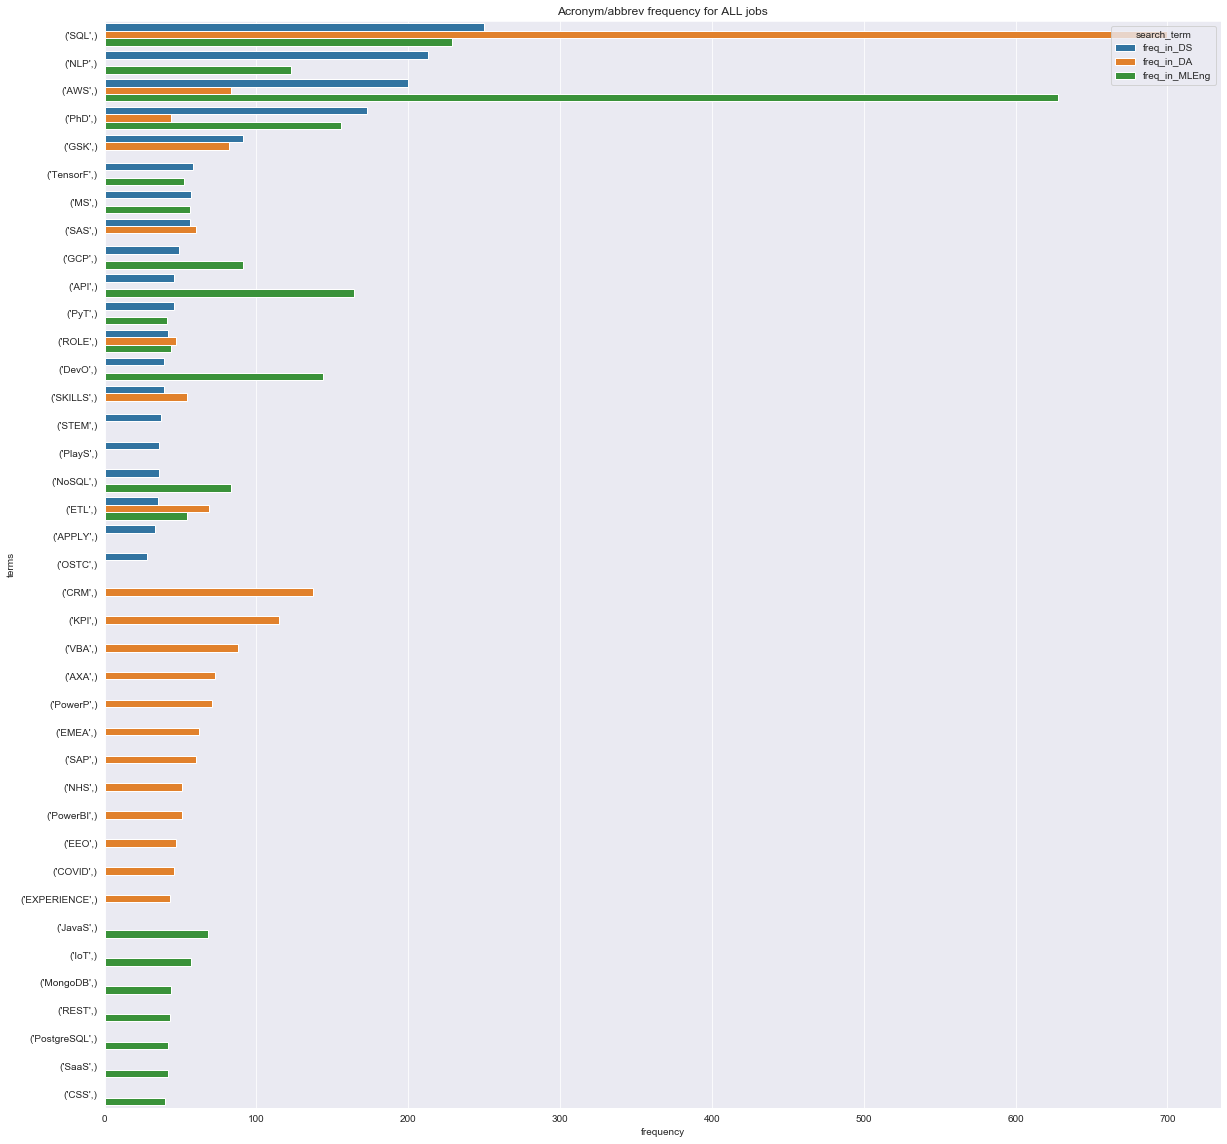

In [219]:
acr_df = fn.plot_term_bar('Acronym/abbrev frequency for ALL jobs',
                           [df.loc[df.searched__data_scientist==1].job_descr, 
                            df.loc[df.searched__data_analyst==1].job_descr,
                           df.loc[df.searched__machine_learning_engineer==1].job_descr], ['DS', 'DA', 'MLEng'],
                          RegexpTokenizer(r'[A-Z]+[a-zA-Z]*[A-Z]'), stop_words, 'Acronym/abbreviation Frequency Distribution for words in descrs in ALL jobs',
                             figsize=(20,20), num_terms=20, lower_case=False, ngram_number=1, save_fig=True, save_fig_name='acronyms_across_all')


So that's the first thing we want to check next, the actual number of job posts that contain AWS in them, for both DS and ML Eng. 

In [220]:
def check_for_str_count(input_str, strings = ['AWS', 'amazon web services', 'GCP', 'cloud', 'azure']):
    x = 0
    for string in strings:
        for token in input_str.split(' '):
            if token==string:
                x+=1
    return x

def check_for_one_str(input_str, strings = ['AWS', 'amazon web services', 'GCP', 'cloud', 'azure']):
    for string in strings:
        if string in input_str:
            return 1
        
    return 0

In [221]:
mleng_df = df.loc[df.searched__machine_learning_engineer==1]
danal_df = df.loc[df.searched__data_analyst==1]
dscie_df = df.loc[df.searched__data_scientist==1]
mleng_df['cloud_mention'] = mleng_df.job_descr.apply(check_for_one_str)
dscie_df['cloud_mention'] = dscie_df.job_descr.apply(check_for_one_str)
danal_df['cloud_mention'] = danal_df.job_descr.apply(check_for_one_str)

print("% DS jobs that mention some form of cloud computing (e.g. AWS, GCP, Azure) is:      ", round(100* dscie_df.cloud_mention.sum()/len(dscie_df),2))
print("% DA jobs that mention some form of cloud computing (e.g. AWS, GCP, Azure) is:      ", round(100* danal_df.cloud_mention.sum()/len(danal_df),2))
print("% ML jobs that mention some form of cloud computing (e.g. AWS, GCP, Azure) is:      ", round(100* mleng_df.cloud_mention.sum()/len(mleng_df), 2))


% DS jobs that mention some form of cloud computing (e.g. AWS, GCP, Azure) is:       31.38
% DA jobs that mention some form of cloud computing (e.g. AWS, GCP, Azure) is:       7.0
% ML jobs that mention some form of cloud computing (e.g. AWS, GCP, Azure) is:       44.12


In [222]:
mleng_df['cloud_num_mention'] = mleng_df.job_descr.apply(check_for_str_count)
dscie_df['cloud_num_mention'] = dscie_df.job_descr.apply(check_for_str_count)
danal_df['cloud_num_mention'] = danal_df.job_descr.apply(check_for_str_count)

In [223]:
print('The mean number of times an DS job post mentions cloud computing is {}'.format(round(dscie_df.cloud_num_mention.mean(),3)))
print('The mean number of times an DA job post mentions cloud computing is {}'.format(round(danal_df.cloud_num_mention.mean(),3)))
print('The mean number of times an ML job post mentions cloud computing is {}'.format(round(mleng_df.cloud_num_mention.mean(),3)))


The mean number of times an DS job post mentions cloud computing is 0.697
The mean number of times an DA job post mentions cloud computing is 0.144
The mean number of times an ML job post mentions cloud computing is 1.494


In [224]:
print('Excluding posts that DON\'T mention cloud computing, the mean number of times an DS job post mentions cloud computing is {}'.format(round(dscie_df.loc[dscie_df.cloud_mention==1].cloud_num_mention.mean(),3)))
print('Excluding posts that DON\'T mention cloud computing, the mean number of times an DA job post mentions cloud computing is {}'.format(round(danal_df.loc[danal_df.cloud_mention==1].cloud_num_mention.mean(),3)))
print('Excluding posts that DON\'T mention cloud computing, the mean number of times an ML job post mentions cloud computing is {}'.format(round(mleng_df.loc[mleng_df.cloud_mention==1].cloud_num_mention.mean(),3)))

Excluding posts that DON'T mention cloud computing, the mean number of times an DS job post mentions cloud computing is 2.222
Excluding posts that DON'T mention cloud computing, the mean number of times an DA job post mentions cloud computing is 2.058
Excluding posts that DON'T mention cloud computing, the mean number of times an ML job post mentions cloud computing is 3.387


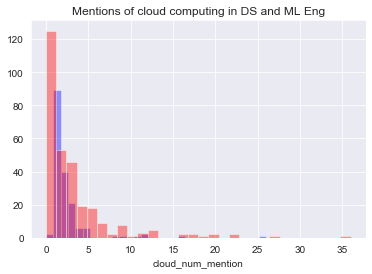

In [225]:
plt.title('Mentions of cloud computing in DS and ML Eng')
sns.distplot(dscie_df.loc[dscie_df.cloud_mention==1].cloud_num_mention, color='b', label = 'Data Sci', kde=False, bins=30)
sns.distplot(mleng_df.loc[mleng_df.cloud_mention==1].cloud_num_mention, color='r', label = 'ML Eng', kde=False, bins=30)

In [226]:
mleng_df['Cloud_mention'] = mleng_df.job_descr.apply(check_for_one_str)
dscie_df['Cloud_mention'] = dscie_df.job_descr.apply(check_for_one_str)

print("% ML jobs that mention any cloud services is: ", round(100*mleng_df.Cloud_mention.sum()/len(mleng_df), 2))
print("% DS jobs that mention any cloud services is: ", round(100* dscie_df.Cloud_mention.sum()/len(dscie_df),2))


% ML jobs that mention any cloud services is:  44.12
% DS jobs that mention any cloud services is:  31.38


In [227]:
mleng_df['cloud_num_mention'] = mleng_df.job_descr.apply(check_for_str_count)
dscie_df['cloud_num_mention'] = dscie_df.job_descr.apply(check_for_str_count)

print('Excluding posts that DON\'T mention cloud services at all, the mean number of times an ML job post mentions cloud services is {}'.format(round(mleng_df.loc[mleng_df.Cloud_mention==1].cloud_num_mention.mean(),3)))
print('Excluding posts that DON\'T mention cloud services at all, the mean number of times an DS job post mentions cloud services is {}'.format(round(dscie_df.loc[dscie_df.Cloud_mention==1].cloud_num_mention.mean(),3)))

Excluding posts that DON'T mention cloud services at all, the mean number of times an ML job post mentions cloud services is 3.387
Excluding posts that DON'T mention cloud services at all, the mean number of times an DS job post mentions cloud services is 2.222


And finally we plot word clouds.

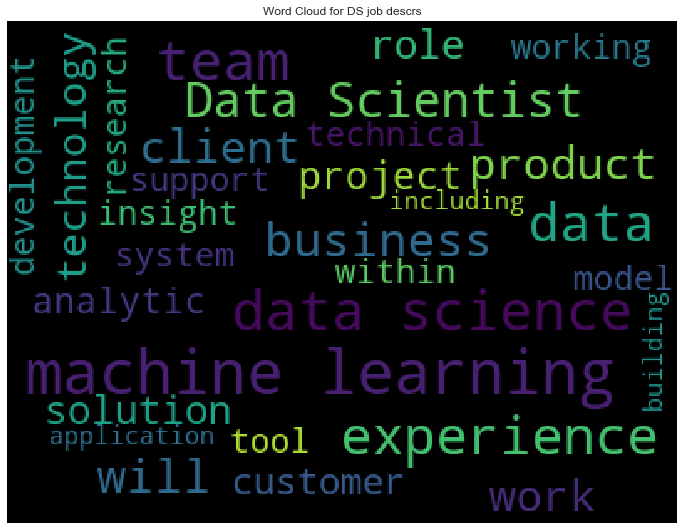

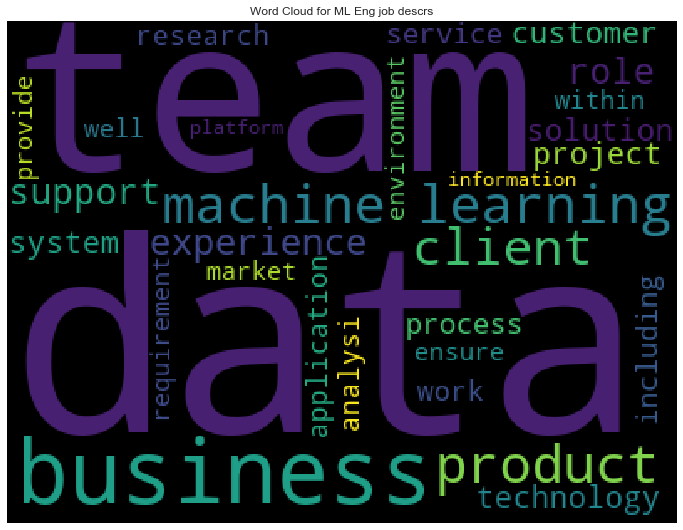

In [228]:
fn.gen_cloud(df.loc[df.searched__data_scientist==1].job_descr, 30, cloud_title='Word Cloud for DS job descrs')
fn.gen_cloud(df.loc[df.searched__data_scientist==0].job_descr, 30, cloud_title='Word Cloud for ML Eng job descrs')

<a id=two ><a/> 

## 3. EDA for salary data
    
[LINK to table of contents](#contents)

How many jobs actually advertise their salary? If our data is representative, then this is not a pretty sight:


In [229]:
print('The percentage of jobs in our sample that openly state any kind of salary range is {}'.format(round(100* len(df.loc[~df.salary_from_page_source_as_stated.isna()])/len(df),2)))

The percentage of jobs in our sample that openly state any kind of salary range is 38.31


In [230]:
print('The absolute nr of DS jobs in our sample that openly state any kind of salary range is     {}'.format((len(dscie_df.loc[~dscie_df.salary_from_page_source_as_stated.isna()]))))
print('The absolute nr of DA jobs in our sample that openly state any kind of salary range is     {}'.format((len(danal_df.loc[~danal_df.salary_from_page_source_as_stated.isna()]))))
print('The absolute nr of ML Eng jobs in our sample that openly state any kind of salary range is {}'.format(len(mleng_df.loc[~mleng_df.salary_from_page_source_as_stated.isna()])))

The absolute nr of DS jobs in our sample that openly state any kind of salary range is     202
The absolute nr of DA jobs in our sample that openly state any kind of salary range is     426
The absolute nr of ML Eng jobs in our sample that openly state any kind of salary range is 219


In [231]:
print('The percentage of DS jobs in our sample that openly state any kind of salary range is     {}'.format(round(100* len(dscie_df.loc[~dscie_df.salary_from_page_source_as_stated.isna()])/len(dscie_df),2)))
print('The percentage of DA jobs in our sample that openly state any kind of salary range is     {}'.format(round(100* len(danal_df.loc[~danal_df.salary_from_page_source_as_stated.isna()])/len(danal_df),2)))
print('The percentage of ML Eng jobs in our sample that openly state any kind of salary range is {}'.format(round(100* len(mleng_df.loc[~mleng_df.salary_from_page_source_as_stated.isna()])/len(mleng_df),2)))

The percentage of DS jobs in our sample that openly state any kind of salary range is     37.06
The percentage of DA jobs in our sample that openly state any kind of salary range is     43.2
The percentage of ML Eng jobs in our sample that openly state any kind of salary range is 32.21


In [232]:
df.salary_from_page_source_time_period.value_counts(True)

Y    0.858156
D    0.111111
W    0.020095
H    0.008274
M    0.002364
Name: salary_from_page_source_time_period, dtype: float64

In [233]:
mleng_df.salary_from_page_source_time_period.value_counts(True)

Y    0.917431
D    0.059633
W    0.022936
Name: salary_from_page_source_time_period, dtype: float64

In [234]:
dscie_df.salary_from_page_source_time_period.value_counts(True)

Y    0.900990
D    0.059406
W    0.024752
H    0.009901
M    0.004950
Name: salary_from_page_source_time_period, dtype: float64

In [235]:
danal_df.salary_from_page_source_time_period.value_counts(True)

Y    0.807512
D    0.161972
W    0.016432
H    0.011737
M    0.002347
Name: salary_from_page_source_time_period, dtype: float64

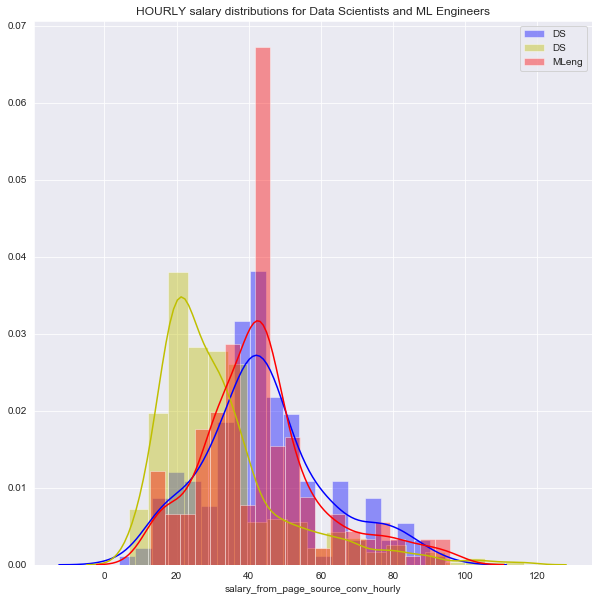

In [236]:
plt.figure(figsize=(10,10))
sns.distplot(df.loc[df['searched__data_scientist']==1].salary_from_page_source_conv_hourly, color='b', label='DS', bins=20)
sns.distplot(df.loc[df['searched__data_analyst']==1].salary_from_page_source_conv_hourly, color='y', label='DS', bins=20)
sns.distplot(df.loc[df['searched__machine_learning_engineer']==1].salary_from_page_source_conv_hourly, color='r', label='MLeng', bins=20)
plt.title('HOURLY salary distributions for Data Scientists and ML Engineers')
plt.legend()
plt.savefig('salary_per_hour.jpeg')
plt.show();

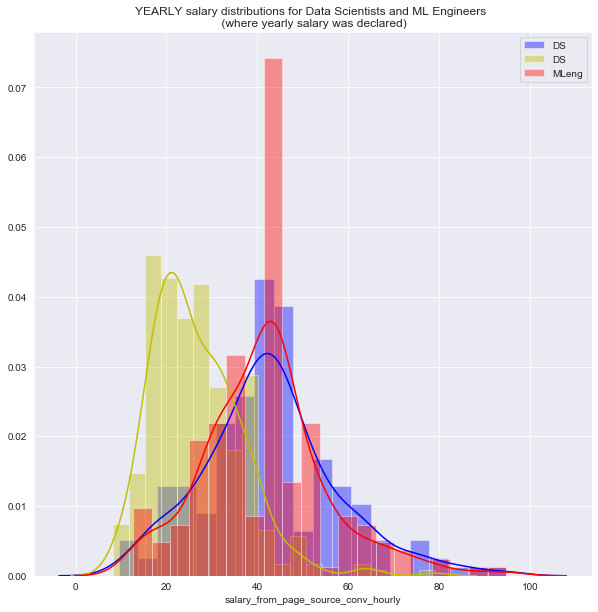

In [237]:
plt.figure(figsize=(10,10))
sns.distplot(df.loc[((df['searched__data_scientist']==1) & (df.salary_from_page_source_time_period=='Y'))].salary_from_page_source_conv_hourly, color='b', label='DS', bins=20)
sns.distplot(df.loc[((df['searched__data_analyst']==1) & (df.salary_from_page_source_time_period=='Y'))].salary_from_page_source_conv_hourly, color='y', label='DS', bins=20)
sns.distplot(df.loc[((df['searched__machine_learning_engineer']==1) & (df.salary_from_page_source_time_period=='Y'))].salary_from_page_source_conv_hourly, color='r', label='MLeng', bins=20)
plt.title('YEARLY salary distributions for Data Scientists and ML Engineers \n (where yearly salary was declared)')
plt.legend()
plt.savefig('yearly_salary_dist.jpeg')
plt.show();

We will perform statistical tests on our data in another notebook (3b_Statistical_tests), so we'll save a smaller version here in another csv.

In [302]:
df.nunique()

company                                 826
job_title                              1540
job_descr                              2016
job_url                                2018
job_location                              1
searched__data_analyst                    2
searched__data_scientist                  2
searched__machine_learning_engineer       2
salary_from_page_source_as_stated       140
salary_from_page_source_conv_hourly     142
salary_from_page_source_time_period       5
Num_reviews                             238
id                                     2211
dtype: int64

In [304]:
salary_df = df.drop_duplicates('job_url', keep=False).drop(columns=['job_descr', 'job_url', 'job_location', 'Num_reviews',  'id'])
salary_df.to_csv('clean_data/salary_data.csv')

### Reviews

In [238]:
comp_reviews = pd.DataFrame({'company':df.company, 'Num_reviews':df.Num_reviews})
comp_reviews = comp_reviews.drop_duplicates()

In [239]:
comp_reviews.tail()

company  Num_reviews
2181  ATS Automation Tooling Systems Inc.          NaN
2190                             Vanguard          NaN
2203                                    R         39.0
2209             People Source Consulting          2.0
2210               Stanley Black & Decker       1775.0

In [240]:
comp_reviews.describe()

Num_reviews
count    397.000000
mean    5170.410579
std    15148.452645
min        2.000000
25%       14.000000
50%      106.000000
75%     1532.000000
max    62707.000000

In [241]:
comp_100 = comp_reviews.loc[comp_reviews.Num_reviews > 100].sort_values(by='Num_reviews', ascending=False)

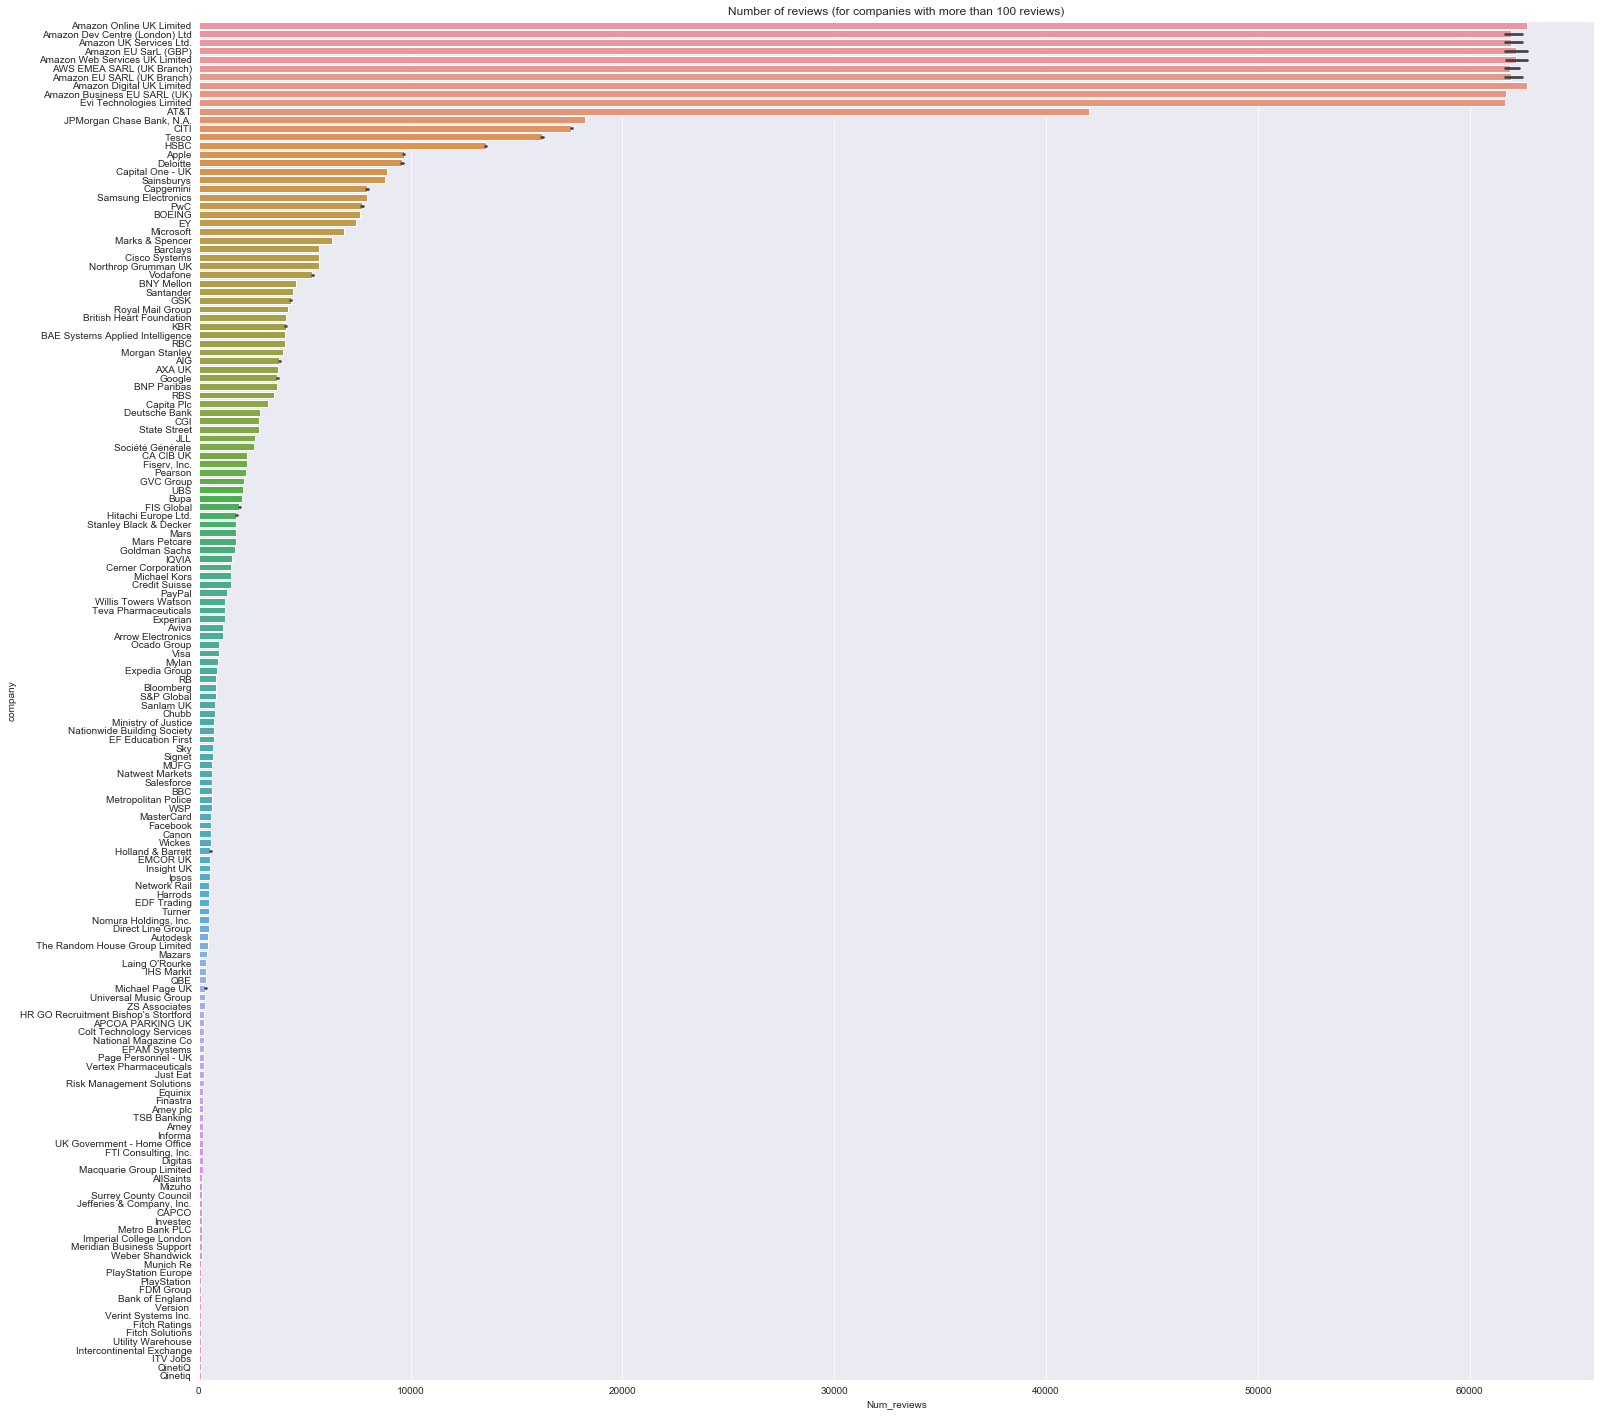

In [242]:
plt.figure(figsize=(25,25))
sns.barplot(comp_100.Num_reviews  , comp_100.company)
plt.title('Number of reviews (for companies with more than 100 reviews)')
plt.show();

<a id=three ><a/> 

## 4. Latent Semantic Analysis for exploration
    
[LINK to table of contents](#contents)

In [243]:
tf_idf_descr = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                         stop_words = stop_word_lst, ngram_range=(1,3),
                        max_df = 0.99,
                        min_df = 0.1)

tf_idf_titles = TfidfVectorizer(tokenizer=RegexpTokenizer(r'[A-Za-z]+').tokenize,
                         stop_words = None, ngram_range=(2,4),
                        max_df=0.95, min_df=0.005)



In [244]:
doc_term_matrix = tf_idf_descr.fit_transform(df.job_descr)

doc_term_df = pd.DataFrame(doc_term_matrix.toarray(), columns = tf_idf_descr.get_feature_names())

doc_term_df.head()

000      2020   ability      able    access   achieve    across    action  \
0  0.0  0.048175  0.000000  0.034251  0.047119  0.000000  0.026679  0.048986   
1  0.0  0.000000  0.092077  0.041126  0.000000  0.000000  0.032034  0.000000   
2  0.0  0.000000  0.050722  0.000000  0.000000  0.047557  0.079407  0.000000   
3  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.0  0.051241  0.108753  0.072862  0.050118  0.000000  0.028376  0.000000   

   activity  additional  ...      want       way       web      well     wide  \
0  0.092907    0.000000  ...  0.000000  0.037268  0.000000  0.059234  0.00000   
1  0.055778    0.000000  ...  0.046734  0.000000  0.000000  0.106685  0.00000   
2  0.046089    0.000000  ...  0.000000  0.036976  0.045665  0.000000  0.00000   
3  0.000000    0.000000  ...  0.161750  0.000000  0.000000  0.000000  0.09744   
4  0.049410    0.104344  ...  0.041399  0.000000  0.000000  0.000000  0.00000   

     within     world     would  written      year  
0  0.052347  0.000000  0.070452      0.0  0.000000  
1  0.157135  0.104855  0.000000      0.0  0.000000  
2  0.000000  0.000000  0.000000      0.0  0.000000  
3  0.054386  0.000000  0.073196      0.0  0.000000  
4  0.055678  0.000000  0.074936      0.0  0.058222  

[5 rows x 429 columns]

In [245]:
doc_term_titles_matrix = tf_idf_titles.fit_transform(df.job_title)

doc_term_titles_df = pd.DataFrame(doc_term_titles_matrix.toarray(), columns = tf_idf_titles.get_feature_names())

doc_term_titles_df.head()

analyst associate  analyst data  analyst sql  artificial intelligence  \
0                0.0           0.0          0.0                      0.0   
1                0.0           0.0          0.0                      0.0   
2                0.0           0.0          0.0                      0.0   
3                0.0           0.0          0.0                      0.0   
4                0.0           0.0          0.0                      0.0   

   bi analyst  big data  big data engineer  business analyst  \
0         0.0       0.0                0.0               0.0   
1         0.0       0.0                0.0               0.0   
2         0.0       0.0                0.0               0.0   
3         0.0       0.0                0.0               0.0   
4         0.0       0.0                0.0               0.0   

   business intelligence  business intelligence analyst  ...  senior analyst  \
0                    0.0                            0.0  ...             0.0   
1                    0.0                            0.0  ...             0.0   
2                    0.0                            0.0  ...             0.0   
3                    0.0                            0.0  ...             0.0   
4                    0.0                            0.0  ...             0.0   

   senior business  senior data  senior data analyst  senior data engineer  \
0              0.0          0.0                  0.0                   0.0   
1              0.0          0.0                  0.0                   0.0   
2              0.0          0.0                  0.0                   0.0   
3              0.0          0.0                  0.0                   0.0   
4              0.0          0.0                  0.0                   0.0   

   senior data scientist  senior software  senior software engineer  \
0                    0.0              0.0                       0.0   
1                    0.0              0.0                       0.0   
2                    0.0              0.0                       0.0   
3                    0.0              0.0                       0.0   
4                    0.0              0.0                       0.0   

   software engineer  solutions architect  
0                0.0                  0.0  
1                0.0                  0.0  
2                0.0                  0.0  
3                0.0                  0.0  
4                0.0                  0.0  

[5 rows x 76 columns]

In [246]:
lsa_obj = TruncatedSVD(n_components=10, n_iter=1000, random_state=22)

lsa_df = pd.DataFrame(lsa_obj.fit_transform(doc_term_df), 
                      columns = [f'Latent_concept_{x+1}' for x in range(lsa_obj.n_components)])
lsa_df.head()

Latent_concept_1  Latent_concept_2  Latent_concept_3  Latent_concept_4  \
0          0.496922          0.052850          0.157404         -0.085803   
1          0.599410          0.085045         -0.041655         -0.054912   
2          0.502736         -0.108528         -0.072468         -0.047770   
3          0.467869         -0.082188         -0.037422         -0.053127   
4          0.503483          0.077038         -0.001797         -0.041361   

   Latent_concept_5  Latent_concept_6  Latent_concept_7  Latent_concept_8  \
0         -0.071325          0.181920         -0.003855         -0.039804   
1          0.035561          0.071970         -0.072179          0.270906   
2          0.107108          0.006269         -0.083214         -0.070825   
3          0.054383          0.055000         -0.068926         -0.003067   
4          0.008773          0.032660          0.107770          0.022228   

   Latent_concept_9  Latent_concept_10  
0         -0.119735           0.105300  
1          0.007195          -0.152221  
2         -0.019964          -0.031035  
3          0.048481          -0.132978  
4         -0.120028          -0.162703

In [247]:
# sns.lineplot(range(len(lsa_obj.components_)), 
             
sum(lsa_obj.explained_variance_ratio_)

0.17303426796086538

In [248]:
V_T = lsa_obj.components_.T
V_T.shape

(429, 10)

In [249]:
term_topic_matrix = pd.DataFrame(data=V_T, 
                                 index = doc_term_df.columns, 
                                 columns = [f'Latent_concept_{x+1}' for x in range(lsa_obj.n_components)])

term_topic_matrix.head()

Latent_concept_1  Latent_concept_2  Latent_concept_3  \
000              0.057137         -0.024177          0.032735   
2020             0.022607         -0.003114          0.002398   
ability          0.088886          0.064148         -0.002281   
able             0.053956          0.035680         -0.010335   
access           0.023974          0.003162         -0.005624   

         Latent_concept_4  Latent_concept_5  Latent_concept_6  \
000             -0.108536         -0.180891         -0.242407   
2020             0.040705         -0.007516         -0.014671   
ability         -0.002517         -0.018001          0.078166   
able            -0.011417         -0.007759          0.016075   
access           0.002931          0.006315          0.005523   

         Latent_concept_7  Latent_concept_8  Latent_concept_9  \
000              0.117442          0.050141         -0.050605   
2020             0.001299          0.015148         -0.009869   
ability          0.000803         -0.036431          0.018451   
able             0.027917          0.013147         -0.036369   
access           0.008834          0.013045         -0.039216   

         Latent_concept_10  
000               0.132516  
2020             -0.004167  
ability          -0.017981  
able              0.005256  
access           -0.008667

## Visualising the latent concepts

The bar charts below represent the term-concepts distributions, ranked by highest to lowest term importance. Thus the words we're seeing in the top 10 are the words that most define the latent concept. From here we can begin to infer some of the meaning of our latent topics. Here are the most prominent ones - remember these are all speculations, attempts at identifying relevant clusters. Only three of them (concepts 3,4 and 8 are ones I'd be highly confident in):
* *Lantent_concept_1* : unknown; very similar to concept_2, but far more generic. The fact that the terms at the opposite end of concept 1's scale indicate that it wouldn't be a very helpful topic for use with prediction or distinguishing any content.
* *Lantent_concept_2* : "business-concern" - general terms about the hiring company and how the prospective employee would contribute
* *Lantent_concept_3* : "NLProc work" - the functions and jobs involving a lot of natural language processing, which coincide with a lot jobs that require / demand research acumen; this result is verified by a similar LDA topic that comes out in notebook 2
* *Lantent_concept_4* : "Cloud platform engineering" - terms like "AWS", "cloud" and "kubernetes" give away the easy meaning of this topic. Articles scoring high in this topic have a strong emphasis on tending to the cloud development side of the business, i.e. maintaining the production side of the business or setting up the customer/client interaction via GCP, Azure or AWS.  
* *Lantent_concept_5*: unknown
* *Lantent_concept_6*: unknown 
* *Lantent_concept_7*: unknown
* *Lantent_concept_8*:"Equal opportunities clause" - job posts scoring highly in this area will be the ones that feature mentions of equal opportunities and overt promises to not discriminate in hiring practices.
* *Lantent_concept_9*: "Business intellignece" - job posts scoring highly here will have mentions of working with or having to understand the needs of the client and of the business
* *Lantent_concept_10* : unknown

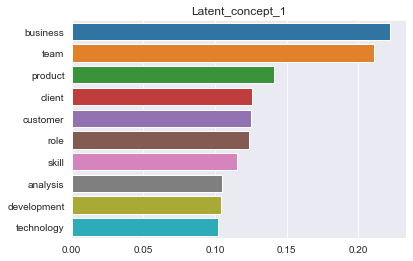

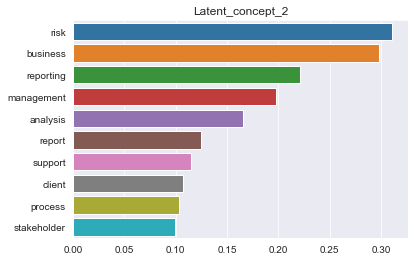

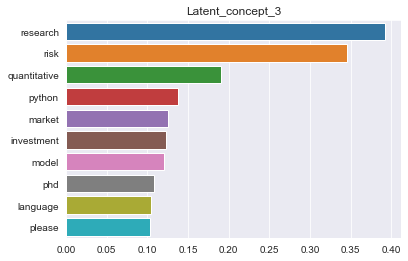

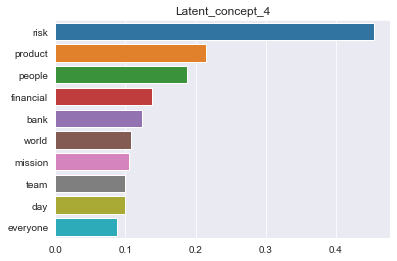

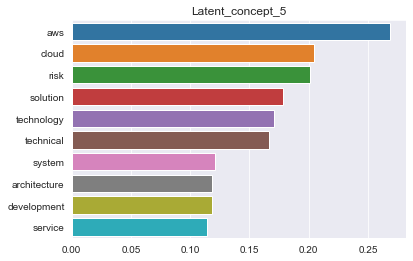

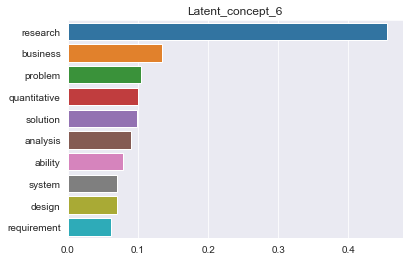

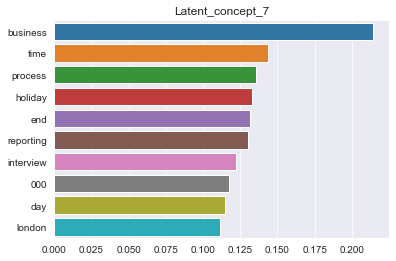

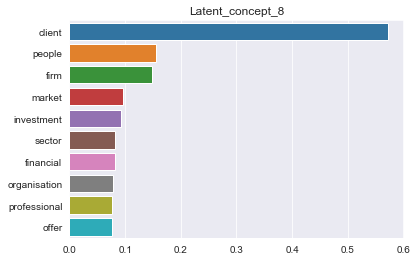

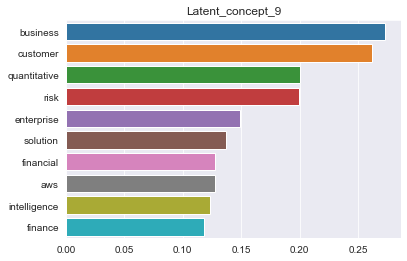

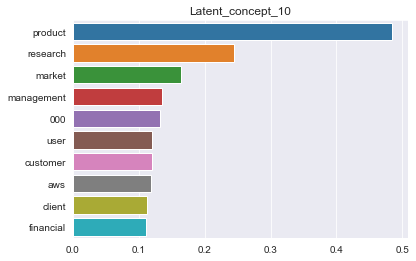

In [250]:
for i in range(1,11):
    data = term_topic_matrix[f'Latent_concept_{i}']
    data = data.sort_values(ascending=False)
    top_10 = data[:10]
    plt.title(f'Latent_concept_{i}')
    sns.barplot(y=top_10.index, x=top_10.values)
    plt.show()

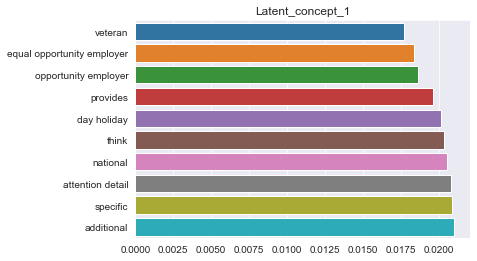

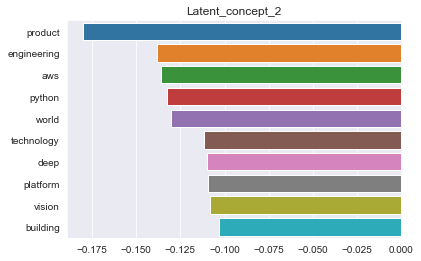

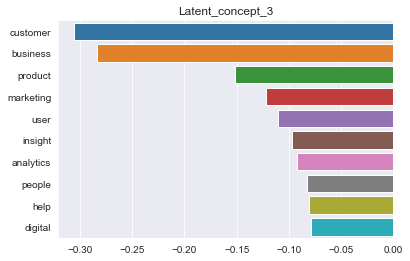

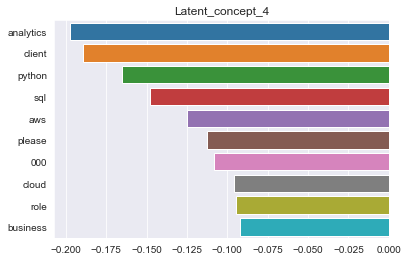

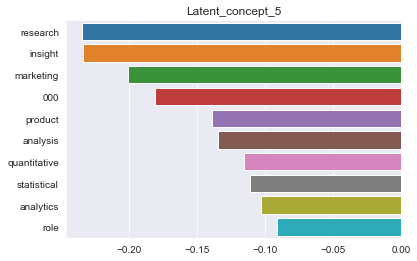

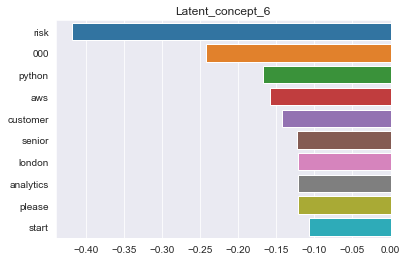

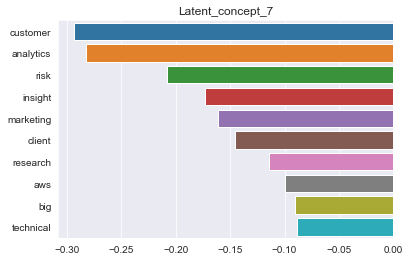

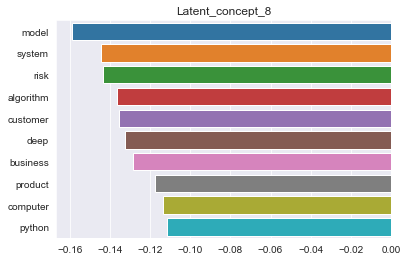

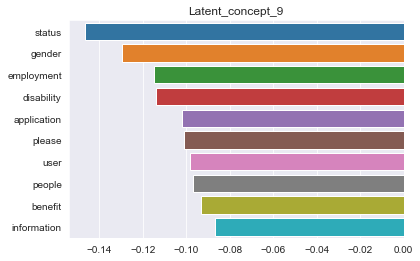

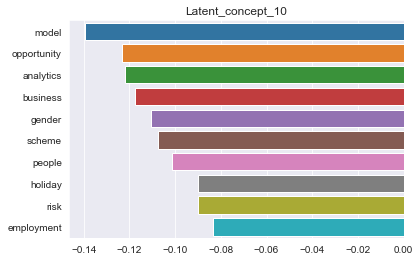

In [252]:
for i in range(1,10):
    data = term_topic_matrix[f'Latent_concept_{i}']
    data = data.sort_values(ascending=True)
    bottom_10 = data[:10]
    plt.title(f'Latent_concept_{i}')
    sns.barplot(y=bottom_10.index, x=bottom_10.values)
    plt.show()

## Can we use LSA topics to predict the search category?

As a demonstrative exercise, we'll use a decision tree and then logistic regression to see how easy it would be to perform binary classification. The target variable is whether or not the job post was searched using the term "data scientist".

In [253]:
train_doc_term_df, test_doc_term_df, train_target, test_target = train_test_split(lsa_df, df.searched__data_scientist, test_size=0.1, random_state=42)

In [254]:
train_target.value_counts()

0    1509
1     480
Name: searched__data_scientist, dtype: int64

In [255]:
from imblearn.under_sampling import RandomUnderSampler as RUS

In [256]:
#subsmapling from majority class
rus = RUS(random_state=42)

train_subsample, train_target_subsample = rus.fit_sample(train_doc_term_df, train_target, )

train_target_subsample.value_counts()

1    480
0    480
Name: searched__data_scientist, dtype: int64

In [257]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
x_train_scaled = minmax.fit_transform(X = train_subsample)
x_test = minmax.transform(X = test_doc_term_df)

In [258]:
tree = DecisionTreeClassifier(min_samples_leaf=.1,
                              random_state=22)

tree.fit(x_train_scaled, train_target_subsample)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=22, splitter='best')

In [259]:
importances = tree.feature_importances_
feats = pd.DataFrame({'features': train_subsample.columns, 'importance': importances})

feats.sort_values(by = 'importance',ascending=False, inplace=True)

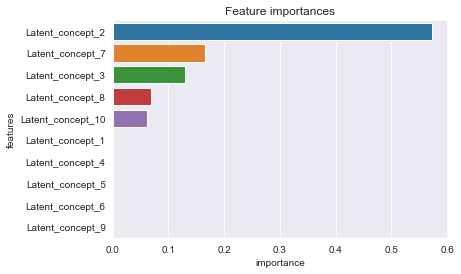

In [260]:
plt.figure()
plt.title("Feature importances")
sns.barplot(x=feats[:20].importance, y = feats[:20].features, orient='h')
plt.show()


In [261]:
from sklearn.inspection import permutation_importance

Whilst permuation importance is significantly more stringent on what it counts as an important feature, we can at least say that concept 2 is of the highest importance. 

In [262]:
result = permutation_importance(tree, train_subsample, train_target_subsample, n_repeats=10,
                                 random_state=42);

<Figure size 576x576 with 0 Axes>

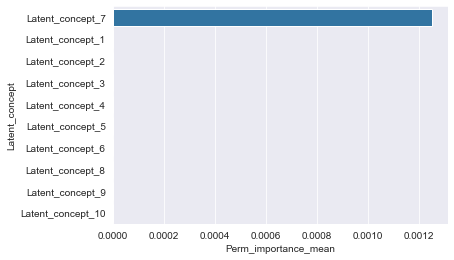

In [263]:
plt.figure(figsize=(8,8))
plt.figure("Permutation importance")

perm_df = pd.DataFrame({'Latent_concept' : train_doc_term_df.columns, 'Perm_importance_mean': result.importances_mean, 'Perm_importance_std': result.importances_std})

perm_df.sort_values(by='Perm_importance_mean', ascending=False, inplace=True, ignore_index=True)

sns.barplot(x=perm_df.Perm_importance_mean,  y=perm_df.Latent_concept, orient='h',) # ci = perm_df.Perm_importance_std) #errwidth=perm_df.Perm_importance_std)
plt.show();

In [264]:
perm_df.head()

Latent_concept  Perm_importance_mean  Perm_importance_std
0  Latent_concept_7               0.00125             0.001021
1  Latent_concept_1               0.00000             0.000000
2  Latent_concept_2               0.00000             0.000000
3  Latent_concept_3               0.00000             0.000000
4  Latent_concept_4               0.00000             0.000000

In [265]:
accuracy_score(test_target, tree.predict(x_test))

0.6036036036036037

In [266]:
import statsmodels.api as sm

In [267]:
x_train.shape

(960, 10)

In [268]:

x_train_scaled = pd.DataFrame(x_train)
x_train_scaled.columns = [f'LC_{i}' for i in range(1,11)]

x_train_scaled = sm.add_constant(x_train_scaled)

In [269]:
logit = sm.Logit(train_target_subsample, x_train_scaled)

logit_fit = logit.fit_regularized(alpha=0.1)

logit_fit.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5163128475491691
            Iterations: 160
            Function evaluations: 160
            Gradient evaluations: 160


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                              
====================================================================================
Dep. Variable:     searched__data_scientist   No. Observations:                  960
Model:                                Logit   Df Residuals:                      949
Method:                                 MLE   Df Model:                           10
Date:                      Fri, 02 Oct 2020   Pseudo R-squ.:                  0.2590
Time:                              10:44:10   Log-Likelihood:                -493.09
converged:                             True   LL-Null:                       -665.42
Covariance Type:                  nonrobust   LLR p-value:                 5.387e-68
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1650      0.818     -1.424      0.154      -2.768       0.438
LC_1           3.1119      0.651      4.777      0.000       1.835       4.389
LC_2           5.7451      0.493     11.649      0.000       4.778       6.712
LC_3           2.1117      0.558      3.784      0.000       1.018       3.206
LC_4          -2.7159      0.453     -5.993      0.000      -3.604      -1.828
LC_5          -2.2489      0.514     -4.375      0.000      -3.256      -1.241
LC_6          -0.4327      0.642     -0.674      0.500      -1.691       0.826
LC_7          -3.2014      0.568     -5.632      0.000      -4.316      -2.087
LC_8          -1.1708      0.471     -2.484      0.013      -2.095      -0.247
LC_9           1.4776      0.519      2.848      0.004       0.461       2.494
LC_10         -2.3580      0.540     -4.364      0.000      -3.417      -1.299
==============================================================================
"""

Once again, we see that LC_2 is by far the most important determiner of whether a job post was searched using "data scientist". Concepts 1, 3, 9 and 10 were also important.  

In [270]:
input_data_test = sm.add_constant(x_test)

In [271]:
input_data_test.shape

(222, 11)

In [272]:
test_target.shape

(222,)

In [273]:
accuracy_score(test_target, 
               logit_fit.predict(input_data_test).round())

0.536036036036036

<a id=conc ><a/> 

## 4. Conclusions and ideas going forward
    
[LINK to table of contents](#contents)

From our albeit limited sample we could reliably predict whether something had been searched under data scientist. This was based mostly on topic 2, which concerns itself with business understanding. Other useful concepts that helped our model identify data scientist jobs were:
* 1 - 'similarly focussed on business understanding', but more generic
* 10- 'product-development'
* 3 - 'python and modelling'

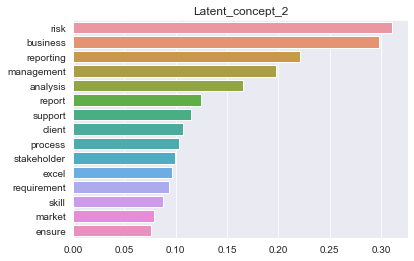

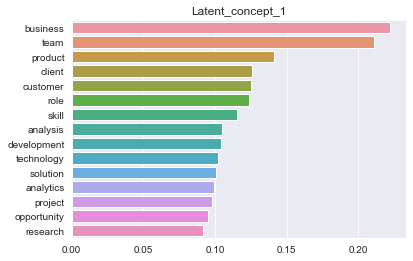

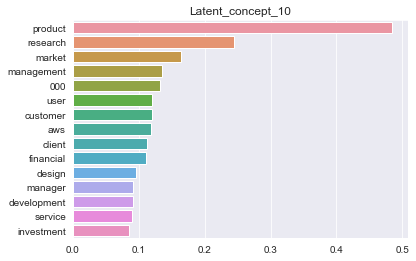

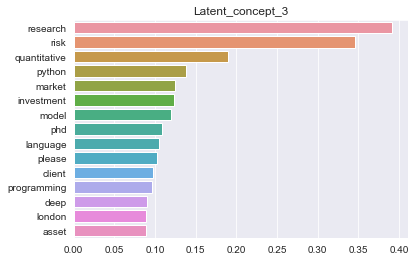

In [275]:
for i in [2, 1, 10, 3]:
    data = term_topic_matrix[f'Latent_concept_{i}']
    data = data.sort_values(ascending=False)
    top_10 = data[:15]
    plt.title(f'Latent_concept_{i}')
    sns.barplot(y=top_10.index, x=top_10.values)
    plt.show()

In [276]:
lsa_df.head()

Latent_concept_1  Latent_concept_2  Latent_concept_3  Latent_concept_4  \
0          0.496922          0.052850          0.157404         -0.085803   
1          0.599410          0.085045         -0.041655         -0.054912   
2          0.502736         -0.108528         -0.072468         -0.047770   
3          0.467869         -0.082188         -0.037422         -0.053127   
4          0.503483          0.077038         -0.001797         -0.041361   

   Latent_concept_5  Latent_concept_6  Latent_concept_7  Latent_concept_8  \
0         -0.071325          0.181920         -0.003855         -0.039804   
1          0.035561          0.071970         -0.072179          0.270906   
2          0.107108          0.006269         -0.083214         -0.070825   
3          0.054383          0.055000         -0.068926         -0.003067   
4          0.008773          0.032660          0.107770          0.022228   

   Latent_concept_9  Latent_concept_10  
0         -0.119735           0.105300  
1          0.007195          -0.152221  
2         -0.019964          -0.031035  
3          0.048481          -0.132978  
4         -0.120028          -0.162703

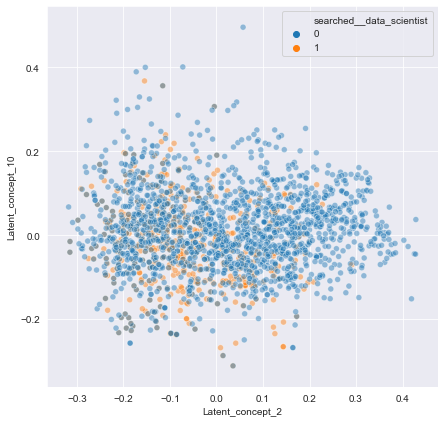

In [297]:
plt.figure(figsize=(7,7))
sns.scatterplot(lsa_df.Latent_concept_2, lsa_df.Latent_concept_10, hue=df.searched__data_scientist, alpha=0.45)
plt.show();